In [1]:
# Import libraries
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv('loan.csv', low_memory=False)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [5]:
df.describe

<bound method NDFrame.describe of             id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      1077501    1296599       5000         5000           4975.0   
1      1077430    1314167       2500         2500           2500.0   
2      1077175    1313524       2400         2400           2400.0   
3      1076863    1277178      10000        10000          10000.0   
4      1075358    1311748       3000         3000           3000.0   
...        ...        ...        ...          ...              ...   
39712    92187      92174       2500         2500           1075.0   
39713    90665      90607       8500         8500            875.0   
39714    90395      90390       5000         5000           1325.0   
39715    90376      89243       5000         5000            650.0   
39716    87023      86999       7500         7500            800.0   

             term int_rate  installment grade sub_grade  ...  \
0       36 months   10.65%       162.87     B        B2  ... 

In [6]:
df.shape

(39717, 111)

In [7]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

There are lot of columns that we need to understand. Knowing what the columns mean can help us a lot for feature engineering.

In [8]:
df_description = pd.read_excel('Data_Dictionary.xlsx')
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,acc_open_past_24mths,Number of trades opened in past 24 months.,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,addr_state,The state provided by the borrower in the loan application,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,all_util,Balance to credit limit on all trades,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,annual_inc,The self-reported annual income provided by the borrower during registration.,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,avg_cur_bal,Average current balance of all accounts,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,bc_open_to_buy,Total open to buy on revolving bankcards.,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.,nan,nan,nan,nan,nan,nan,nan,nan,nan


# Data Cleaning

In [9]:
missing = round(100*(df.isnull().sum()/len(df.id)), 2)
missing.loc[missing > 0]

emp_title                       6.19
emp_length                      2.71
desc                           32.58
title                           0.03
mths_since_last_delinq         64.66
                               ...  
tax_liens                       0.10
tot_hi_cred_lim               100.00
total_bal_ex_mort             100.00
total_bc_limit                100.00
total_il_high_credit_limit    100.00
Length: 68, dtype: float64

There are many columns in the data with 100% missing values. Lets remove all the columns with more than 50% missing values.

In [10]:
columns_with_missing_values = list(missing[missing >= 50].index)

len(columns_with_missing_values)

57

There are 57 columns with more than 50% values as missing, let's remove these columns

In [11]:
df = df.drop(columns_with_missing_values,axis=1)
df.shape

(39717, 54)

Let's examine missing values further

In [12]:
missing = round(100*(df.isnull().sum()/len(df.id)), 2)
missing[missing != 0]

emp_title                      6.19
emp_length                     2.71
desc                          32.58
title                          0.03
revol_util                     0.13
last_pymnt_d                   0.18
last_credit_pull_d             0.01
collections_12_mths_ex_med     0.14
chargeoff_within_12_mths       0.14
pub_rec_bankruptcies           1.75
tax_liens                      0.10
dtype: float64

let's remove the desc column as this information is present in the purpose and title column of the dataset.

In [13]:
df = df.drop('desc',axis=1)

In [14]:
print("unique emp_title : %d"  % len(df.emp_title.unique()))
print("unique emp_length : %d"  % len(df.emp_length.unique()))
print("unique title : %d"  % len(df.title.unique()))
print("unique revol_util : %d"  % len(df.revol_util.unique()))
print("unique title : %d"  % len(df.title.unique()))
print("unique last_pymnt_d : %d"  % len(df.last_pymnt_d.unique()))
print("unique last_credit_pull_d : %d"  % len(df.last_credit_pull_d.unique()))
print("unique collections_12_mths_ex_med : %d"  % len(df.collections_12_mths_ex_med.unique()))
print("unique chargeoff_within_12_mths : %d"  % len(df.chargeoff_within_12_mths.unique()))
print("unique pub_rec_bankruptcies : %d"  % len(df.pub_rec_bankruptcies.unique()))
print("unique tax_liens : %d"  % len(df.tax_liens.unique()))

unique emp_title : 28821
unique emp_length : 12
unique title : 19616
unique revol_util : 1090
unique title : 19616
unique last_pymnt_d : 102
unique last_credit_pull_d : 107
unique collections_12_mths_ex_med : 2
unique chargeoff_within_12_mths : 2
unique pub_rec_bankruptcies : 4
unique tax_liens : 2


Let's examine unique values of some of the categorical columns

In [15]:
df.emp_length.unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [16]:
df.collections_12_mths_ex_med.unique()

array([ 0., nan])

In [17]:
df.chargeoff_within_12_mths.unique()

array([ 0., nan])

In [18]:
df.pub_rec_bankruptcies.unique()

array([ 0.,  1.,  2., nan])

In [19]:
df.tax_liens.unique()

array([ 0., nan])

Columns collections_12_mths_ex_med, chargeoff_within_12_mths and tax_liens has either value of 0 or nan. The range of values that these categorical columns can take is not of any significant impact to the analysis.
We can drop these columns for analysis.

In [20]:
drop_columnlist = ['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens']
df = df.drop(drop_columnlist,axis=1)

Next, lets look at the pub_rec_bankruptcies categorical column with 1.76% missing data. It tells us about the past number of public record bankruptcies of that borrower.

In [21]:
df.pub_rec_bankruptcies.value_counts()

0.0    37339
1.0     1674
2.0        7
Name: pub_rec_bankruptcies, dtype: int64


pub_rec_bankruptcies can be seen to have taking values like [0,1,2]. Almost 35000 records with 0 record of bankrupcies.
Lets remove the rows so that we ensure we dont add any bais to the data.

In [22]:
df=df[~df.pub_rec_bankruptcies.isnull()]

In [23]:
missing = round(100*(df.isnull().sum()/len(df.id)), 2) 
missing[missing != 0]

emp_title       6.19
emp_length      2.75
title           0.03
revol_util      0.13
last_pymnt_d    0.18
dtype: float64

The columns emp_title, emp_length have 6.19% and 2.71% missing value. These columns have information about the customer/borrower like their job title and their employment length in years. Let's remove the rows with nan/blank values for these varaibles.

In [24]:
df=df[~df.emp_title.isnull()]
df=df[~df.emp_length.isnull()]

In [25]:
missing = round(100*(df.isnull().sum()/len(df.id)), 2) 
missing[missing != 0]

title           0.02
revol_util      0.13
last_pymnt_d    0.18
dtype: float64

Now, we are left with 3 columns title, revol_util and last_pymnt_d which account for a very small % of missing value of 0.02%, 0.13% and 0.18% respectively.
title gives the title of the loan specified by the borrower in the application.
revol_util gives the revolving line utelization and
last_pymnt_d gives the month in which last payment was received.

Let's again remove the rows with null value for these variables.

In [26]:
df=df[~df.title.isnull()]
df=df[~df.revol_util.isnull()]
df=df[~df.last_pymnt_d.isnull()]

In [27]:
missing =round(100*(df.isnull().sum()/len(df.id)), 2) 
missing[missing != 0]

Series([], dtype: float64)

Now, we have now reduced the data set to have 36433 loan records and 50 attributes with no missing values. 

Let's now analyse all the columns in the resulted dataframe and find only the ones with are required or make sense for the analysis.

In [28]:
clean_loan = df[:]

In [29]:
clean_loan.nunique().sort_values()

acc_now_delinq                 1
application_type               1
policy_code                    1
initial_list_status            1
delinq_amnt                    1
pymnt_plan                     1
term                           2
pub_rec_bankruptcies           3
loan_status                    3
verification_status            3
home_ownership                 4
pub_rec                        5
grade                          7
inq_last_6mths                 9
delinq_2yrs                   11
emp_length                    11
purpose                       14
sub_grade                     35
open_acc                      38
addr_state                    49
issue_d                       52
total_acc                     79
last_credit_pull_d            96
last_pymnt_d                  97
int_rate                     334
earliest_cr_line             510
zip_code                     806
loan_amnt                    863
funded_amnt                 1024
out_prncp                   1064
out_prncp_

A data dictionary file is also been provided along with the loan data. This file gives a brief describtion about all the columns of the loan transaction file.
Let's use this file to get a better understanding of the 50 columns we are left with.
This will help to further narrow down on the columns.

There are a few columns having a single unique value or all unique values. These may have nothing much to contribute to the analysis i.e. columns which are far from being the driving columns towards loan default. Some other columns are redundant.

These columns are:
1. __id__
:<br>is a random number given to the loan, does not contribute to analysis
2. __member_id__
:<br>is a random number given to the member, does not contribute to analysis
3. __pymnt_plan__
:<br> value for entire dataset is 'n', therefore can be removed.
4. __url__
:<br>is a URL for LC page for corresponding to each memberid, nothing to do with loan default.
5. __zip_code__
:<br>first 3 digits of the 5 digit zip code are visible, also is redundant with addr_state, does not contribute to analysis
6. __initial_list_status__
:<br> value for entire dataset is 'f' out of the possible values, therefore can be removed.
7. __policy_code__
:<br> value for entire dataset is '1', indicating all are publicly available, therefore nothing to contribute for analysis, to be removed.
8. __application_type__
:<br>value for entire dataset is 'INDIVIDUAL', indicating all are individual applications not joint, therefore nothing to contribute for analysis, to be removed.
9. __acc_now_delinq__
:<br>value for entire dataset is '0', therefore can be removed.
10. __delinq_amnt__
:<br>value for entire dataset is '0', therefore can be removed.
11. __funded_amnt__
:<br> value for this column is almost equivalent to loan_amnt. removing to avoid multi colinearity.
12. __funded_amnt_inv__
:<br> value for this column is almost equivalent to funded_amnt. removing to avoid multi colinearity. Also this wont be available at the time of decision making of funding a loan.

Dropping the above columns from the clean_loan dataframe.

In [30]:
columns_tobe_dropped = ['id','member_id','funded_amnt','funded_amnt_inv','pymnt_plan','url','zip_code','initial_list_status','policy_code','application_type','acc_now_delinq','delinq_amnt',]
clean_loan= clean_loan.drop(columns_tobe_dropped,axis=1)

In [31]:
clean_loan.shape

(36433, 38)

Next, let's standardize the precision of the data. There are certain columns with need rounding of the values up until two decimal places.
These columns are:

total_pymnt
total_rec_late_fee
collection_recovery_fee

In [32]:
clean_loan.total_pymnt.value_counts().tail()

26402.662500    1
11055.802500    1
1749.750265     1
19914.641810    1
4278.294070     1
Name: total_pymnt, dtype: int64

In [33]:
clean_loan.total_rec_late_fee.value_counts().tail()

37.323504    1
14.977710    1
14.896508    1
14.971231    1
14.939744    1
Name: total_rec_late_fee, dtype: int64

In [34]:
clean_loan.collection_recovery_fee.value_counts().tail()

1.5778      1
764.7710    1
7.3200      1
10.9890     1
118.1412    1
Name: collection_recovery_fee, dtype: int64

In [35]:
clean_loan.total_pymnt= round(clean_loan.total_pymnt,2)
clean_loan.total_rec_late_fee= round(clean_loan.total_rec_late_fee,2)
clean_loan.collection_recovery_fee= round(clean_loan.collection_recovery_fee,2)

Next, there are few columns which denote date or month information but are of the type object in the dataframe. Let's change the dtype of all such columns to datetime. Doing so will help in further using these column values to its best for analysis.<br>
These columns are:
1. issue_d
2. earliest_cr_line
3. last_pymnt_d
4. last_credit_pull_d

In [36]:
datetime_colmns=['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
clean_loan[datetime_colmns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36433 entries, 1 to 39680
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   issue_d             36433 non-null  object
 1   earliest_cr_line    36433 non-null  object
 2   last_pymnt_d        36433 non-null  object
 3   last_credit_pull_d  36433 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


Converting the dtype of these columns to datetime

In [37]:
clean_loan.issue_d = pd.to_datetime(clean_loan.issue_d, format='%b-%y')
clean_loan.earliest_cr_line = pd.to_datetime(clean_loan.earliest_cr_line, format='%b-%y')
clean_loan.last_pymnt_d = pd.to_datetime(clean_loan.last_pymnt_d, format='%b-%y')
clean_loan.last_credit_pull_d = pd.to_datetime(clean_loan.last_credit_pull_d, format='%b-%y')

In [38]:
clean_loan[datetime_colmns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36433 entries, 1 to 39680
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   issue_d             36433 non-null  datetime64[ns]
 1   earliest_cr_line    36433 non-null  datetime64[ns]
 2   last_pymnt_d        36433 non-null  datetime64[ns]
 3   last_credit_pull_d  36433 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 1.4 MB


Dropping Duplicated rows if any,

In [39]:
clean_loan.shape

(36433, 38)

In [40]:
clean_loan=clean_loan.drop_duplicates()

In [41]:
clean_loan.shape

(36433, 38)

Next, there are few columns expressing % like int_rate and revol_util.
<br> These has values like '15.27%' and '9.40%'.
<br>Further these columns has dtype as 'object'. Let's convert these columns to have just the value withoout '%' and typecast it to float.

In [42]:
clean_loan.int_rate.describe()

count      36433
unique       334
top       10.99%
freq         901
Name: int_rate, dtype: object

In [43]:
clean_loan.revol_util.describe()

count     36433
unique     1082
top          0%
freq        852
Name: revol_util, dtype: object

In [44]:
clean_loan['int_rate'] = clean_loan['int_rate'].str.strip('%').astype('float')
clean_loan['revol_util'] = clean_loan['revol_util'].str.strip('%').astype('float')

In [45]:
clean_loan[['int_rate','revol_util']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36433 entries, 1 to 39680
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   int_rate    36433 non-null  float64
 1   revol_util  36433 non-null  float64
dtypes: float64(2)
memory usage: 853.9 KB


Let us now take a look at the emp_length column.

In [46]:
clean_loan.emp_length.value_counts()

10+ years    8407
2 years      4178
< 1 year     4052
3 years      3914
4 years      3297
5 years      3129
1 year       3026
6 years      2121
7 years      1697
8 years      1405
9 years      1207
Name: emp_length, dtype: int64

According to the data_dictionary file description for this field,
emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
Let's convert the column to have values between 0 and 10.

In [47]:
emp_length_dict = {
    '< 1 year' : 0,
    '1 year' : 1,
    '2 years' : 2,
    '3 years' : 3,
    '4 years' : 4,
    '5 years' : 5,
    '6 years' : 6,
    '7 years' : 7,
    '8 years' : 8,
    '9 years' : 9,
    '10+ years' : 10
}

In [48]:
clean_loan = clean_loan.replace({"emp_length": emp_length_dict })

In [49]:
clean_loan.emp_length.value_counts()

10    8407
2     4178
0     4052
3     3914
4     3297
5     3129
1     3026
6     2121
7     1697
8     1405
9     1207
Name: emp_length, dtype: int64

The column term: The number of payments on the loan. Values are in months and can be either 36 or 60.
removing the months string from within the column term.

In [50]:
clean_loan.term.value_counts()

 36 months    26377
 60 months    10056
Name: term, dtype: int64

In [51]:
clean_loan['term'] = clean_loan.term.apply(lambda x: x.split()[0])

In [52]:
clean_loan.term.value_counts()

36    26377
60    10056
Name: term, dtype: int64

earliest_cr_line:** The month the borrower's earliest reported credit line was opened. Let's split the date column into earliest_cr_line_month and earliest_cr_line_year

Lets split the available date into month and year column.

In [53]:
clean_loan['earliest_cr_line_month'] = clean_loan['earliest_cr_line'].dt.month
clean_loan['earliest_cr_line_year'] = clean_loan['earliest_cr_line'].dt.year

In [54]:
len(clean_loan[clean_loan['earliest_cr_line_year'] > 2011 ])

50

We see that there are 50 records with the earliest credit line date greater than 2011(which is the max range of the data we have).
Lets see the data to understand why.

In [55]:
clean_loan[clean_loan['earliest_cr_line_year'] > 2011 ]['earliest_cr_line_year'].unique()

array([2068, 2067, 2065, 2063, 2066, 2062, 2056, 2046, 2050, 2064, 2054])

This seems to be a result of y2k like error. Year stored in two digits being interpreted as year in 21st century. Let's fix the entries.

In [56]:
clean_loan.loc[clean_loan['earliest_cr_line_year'] > 2011 , 'earliest_cr_line_year'] = clean_loan['earliest_cr_line_year'] - 100

In [57]:
clean_loan.groupby('earliest_cr_line_year').loan_amnt.count()

earliest_cr_line_year
1946       1
1950       1
1954       1
1956       1
1962       3
1963       4
1964       2
1965       6
1966       7
1967      12
1968      12
1969      22
1970      35
1971      34
1972      33
1973      41
1974      51
1975      57
1976      73
1977      90
1978     130
1979     141
1980     150
1981     154
1982     196
1983     296
1984     360
1985     406
1986     447
1987     565
1988     671
1989     781
1990     944
1991     884
1992     970
1993    1398
1994    1860
1995    1974
1996    2074
1997    2271
1998    2645
1999    2763
2000    3034
2001    2363
2002    1794
2003    1740
2004    1639
2005    1406
2006    1079
2007     668
2008     144
Name: loan_amnt, dtype: int64

issue_d: The month which the loan was funded .Lets split the available date into month and year column.

In [58]:
clean_loan['issue_d_month'] = clean_loan['issue_d'].dt.month
clean_loan['issue_d_year'] = clean_loan['issue_d'].dt.year

    As per Data Disctionary, Variable home_ownership has 4 valid values - RENT, OWN, MORTGAGE, OTHER. However, in
    data, there are 3 records whose value is NONE. Since record is very minimum and doesn't add any significant 
    value, so dropping rows of those 3 records.

In [59]:
# Dropping Record where home_ownership = NONE
clean_loan = clean_loan[clean_loan.home_ownership != 'NONE']

# Dropping any Duplicate Rows, if any (Keeping the First Value and dropping the rest)
clean_loan.drop_duplicates(keep = 'first', inplace = True)

In [60]:
clean_loan.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies,earliest_cr_line_month,earliest_cr_line_year,issue_d_month,issue_d_year
1,2500,60,15.27,59.83,C,C4,Ryder,0,RENT,30000.0,...,117.08,1.11,2013-04-01,119.66,2013-09-01,0.0,4,1999,12,2011
3,10000,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,RENT,49200.0,...,0.00,0.00,2015-01-01,357.48,2016-04-01,0.0,2,1996,12,2011
4,3000,60,12.69,67.79,B,B5,University Medical Group,1,RENT,80000.0,...,0.00,0.00,2016-05-01,67.79,2016-05-01,0.0,1,1996,12,2011
5,5000,36,7.90,156.46,A,A4,Veolia Transportaton,3,RENT,36000.0,...,0.00,0.00,2015-01-01,161.03,2016-01-01,0.0,11,2004,12,2011
6,7000,60,15.96,170.08,C,C5,Southern Star Photography,8,RENT,47004.0,...,0.00,0.00,2016-05-01,1313.76,2016-05-01,0.0,7,2005,12,2011


# Analysis

In [61]:
clean_loan.shape

(36433, 42)

In [62]:
master_loan = clean_loan[:]

In [63]:
master_loan.loan_status.value_counts()

Fully Paid     30424
Charged Off     4943
Current         1066
Name: loan_status, dtype: int64

Since we need to understand differences in the features between loans that have been fully paid or charged off. Let's not consider loans that are current. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [64]:
master_loan = master_loan[master_loan['loan_status'].isin(['Fully Paid','Charged Off'])]
master_loan.shape

(35367, 42)

# Univariate  Analysis

In [65]:
#taken from https://stackoverflow.com/a/48372659 and edited
def showLabels(ax, d=None):
    plt.margins(0.2, 0.2)
    rects = ax.patches
    i = 0
    locs, labels = plt.xticks() 
    counts = {}
    if not d is None:
        for key, value in d.items():
            counts[str(key)] = value

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if d is None:
            label = "{:.1f}%".format(y_value)
        else:
            try:
                label = "{:.1f}%".format(y_value) + "\nof " + str(counts[str(labels[i].get_text())])
            except:
                label = "{:.1f}%".format(y_value)
        
        i = i+1

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [66]:
# This function plots a given column buckets against loan_status (default = 'Charged Off')
# The plots are in percentages 
# (absolute numbers do not make sense -> category values can have very different absolute numbers)
# We want to see what are the chances of some category leading to loan default
# Absolute numbers are also printed to assess level of confidence in a % value. 
def plotLoanStatus(dataframe, by, loanstatus='Charged Off'):
    grp = dataframe.groupby(['loan_status',by])[by].count()
    cnt = dataframe.groupby(by)[by].count()
    #print(grp)
    percentages = grp.unstack() * 100 / cnt.T
    ax = percentages.loc[loanstatus].plot.bar(color=sns.color_palette('husl', 16))
    ax.set_ylabel('% of loans ' + loanstatus)
    showLabels(ax, grp[loanstatus].to_dict())
    plt.margins(0.2, 0.2)
    plt.tight_layout()
    return ax

In [67]:
# This method plots a distribution of target column, and its boxplot against loan_status column
def plot_distribution(dataframe, col):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    ax = sns.distplot(dataframe[col])
    plt.subplot(1, 2, 2)
    sns.boxplot(x=dataframe[col], y=dataframe['loan_status'], data=dataframe)
    plt.show()

In [68]:
# This method prints two plots side by side 
# Left one is percentage of a categorical variable in the entire dataset 
# Right one is percentage for Charged Off loans 
# Significant changes in percentage from left to right can indicate a value of interest
def plot_percentages(dataframe, by, sortbyindex=False):
    plt.subplot(1, 2, 1)
    values = (master_loan[by].value_counts(normalize=True)*100)
    if sortbyindex:
        values = values.sort_index()
    ax = values.plot.bar(color=sns.color_palette('husl', 16))
    ax.set_ylabel('% in dataset', fontsize=16)
    ax.set_xlabel(by, fontsize=12)
    showLabels(ax)
    plt.subplot(1, 2, 2)
    #ax = master_loan.groupby('loan_status')['term'].value_counts(normalize=True).loc[:'Charged Off'].plot.bar(color=sns.color_palette('husl', 16))
    values = (master_loan.loc[master_loan['loan_status']=='Charged Off'][by].value_counts(normalize=True)*100)
    if sortbyindex:
        values = values.sort_index()
    ax = values.plot.bar(color=sns.color_palette('husl', 16))
    ax.set_ylabel('% in Charged Off loans', fontsize=16)
    showLabels(ax)

In [69]:
(master_loan['grade'].value_counts(normalize=True)*100).sort_index()

A    25.843300
B    30.305087
C    20.304238
D    13.184607
E     7.015014
F     2.550400
G     0.797353
Name: grade, dtype: float64

---
### **The key column - loan_status**

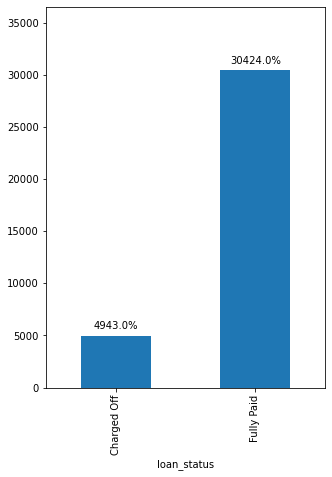

In [70]:
plt.figure(figsize=(5,7))
ax = master_loan.groupby('loan_status').loan_amnt.count().plot.bar()
showLabels(ax)
plt.show()

In [71]:
print("%.2f" % (master_loan.loc[master_loan['loan_status'] == 'Charged Off'].loan_status.count() * 100/len(master_loan)))

13.98


---
<mark>Approximately **14%** of loans in the dataset are **defaulted.**</mark>
<br>Any variable that increases percentage of default to higher than 16.5% should be considered a business risk. 
(16.5 is 18% higher than 13.97 - a large enough increase) 

---

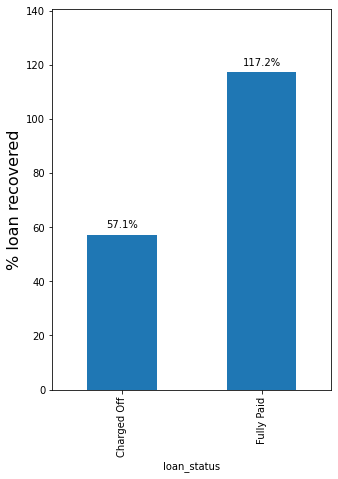

In [72]:
plt.figure(figsize=(5,7))
ax = (master_loan.groupby('loan_status').total_pymnt.sum() * 100 / master_loan.groupby('loan_status').loan_amnt.sum()).plot.bar()
ax.set_ylabel('% loan recovered', fontsize=16)
plt.margins(0.2, 0.2)
showLabels(ax)

Lending Club only recovers 57% of the loan amount when loans are defaulted. On fully paid up loans, the company makes 17% profit.

### Let us see graphs of some other important variables 

#### Variable: loan_amnt
Data_Dictionary: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

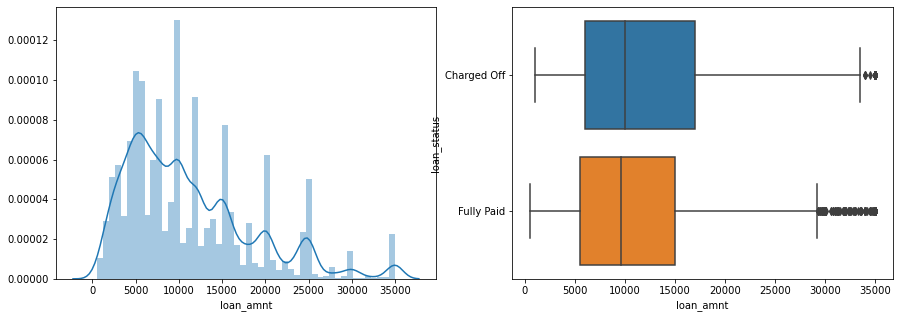

In [73]:
plot_distribution(master_loan, 'loan_amnt')

In [74]:
master_loan.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,4943.0,12286.147077,8064.255961,1000.0,6000.0,10000.0,17000.0,35000.0
Fully Paid,30424.0,10945.731166,7181.867451,500.0,5500.0,9600.0,15000.0,35000.0


**Observation:**
-  Overall, the applied loan amount distribution is slightly __right-skewed__ with mean greater than the median. Most of the loans granted are below 15000 (75 percentile value)
- Funding amounts see a spike around each 5000 boundary. <mark>We will use 5000 as bucket size for later analysis.</mark>
- Charged off loans are shifted towards higher average loan amount request.

In [75]:
#Create Derived categorical variable
master_loan['loan_amnt_bin'] = pd.cut(master_loan['loan_amnt'], 
                                      [x for x in range(0, 36000, 5000)], labels=[str(x)+'-'+str(x+5)+'k' for x in range (0, 35, 5)])


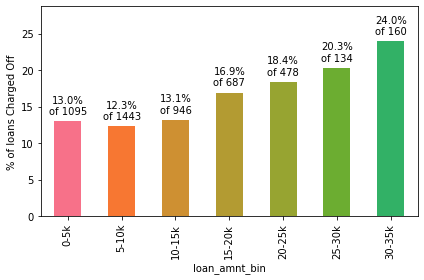

In [76]:
plotLoanStatus(master_loan, 'loan_amnt_bin')

Observation:

The % of charged off loans increases substancially as we go up the loan amount buckets. Most loans are below 20000 amount. The higher loans, though lesser in number, carry a substantially higher risk of default.

---
#### Other categorical variables distribution
Let's see how some other categorical variables of interest are distributed within the dataset 

In [77]:
def categoricalBarPlots(df, arr):
    rows = int(len(arr)/2)
    for idx, val in enumerate(arr, start=1):
        plt.subplot(rows, 2, idx)
        ax = df.groupby(val).loan_amnt.count().plot.bar(color=sns.color_palette('husl', 16))
        showLabels(ax)

    plt.tight_layout()

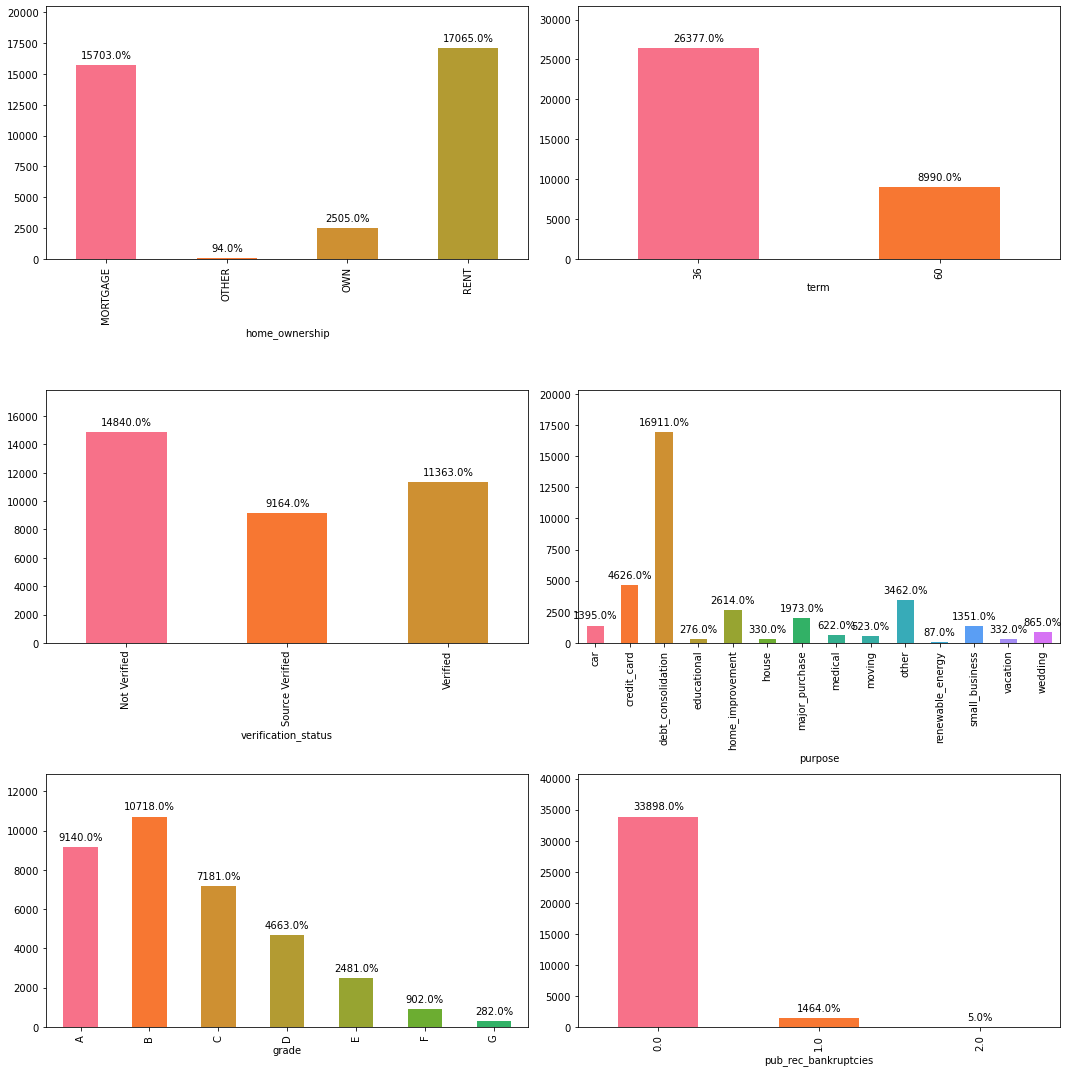

In [78]:
plt.figure(figsize=(15,15))

categoricalBarPlots(master_loan, ['home_ownership', 'term', 'verification_status', 'purpose', 'grade', 'pub_rec_bankruptcies'])

**Obervation**
* Most loans are for 36 month term 
* Very few loans are extended to people with prior record of bankruptcy
* debt_consolidation is by far the largest 'purpose' for seeking a loan 
* Most approved loans are high grade
* <mark> We should investigate the **frequencies of defaults** by term, purpose and prior record of bankruptcy </mark>

---
#### Power Law
Do some of these variables exhibit the power law? Let's see. 

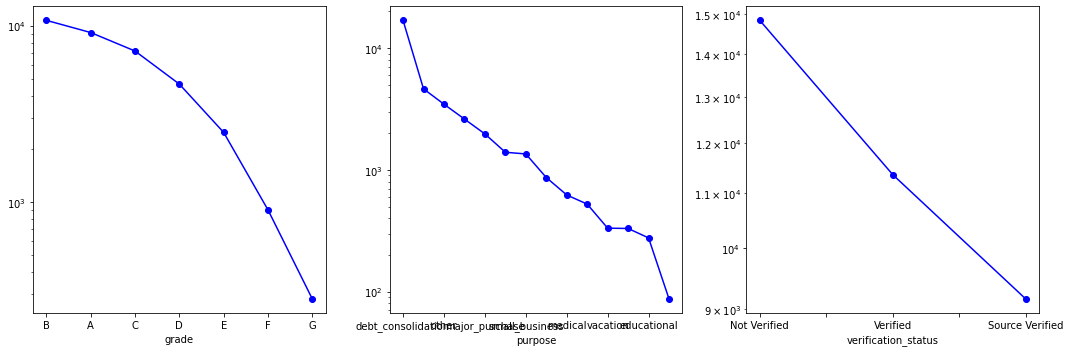

In [79]:
#Let's see if some of these variables follow the famous power law.
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
master_loan.groupby('grade').loan_amnt.count().sort_values(ascending=False).plot(kind='line', logy=True, marker='o', color='b')
plt.subplot(1, 3, 2)
master_loan.groupby('purpose').loan_amnt.count().sort_values(ascending=False).plot(kind='line', logy=True, marker='o', color='b')
plt.subplot(1, 3, 3)
master_loan.groupby('verification_status').loan_amnt.count().sort_values(ascending=False).plot(kind='line', logy=True, marker='o', color='b')
plt.tight_layout()

<mark>purpose and verification_status follow the power law</mark>

---
#### Variable: term
Data_Dictionary: The number of payments on the loan. Values are in months and can be either 36 or 60.

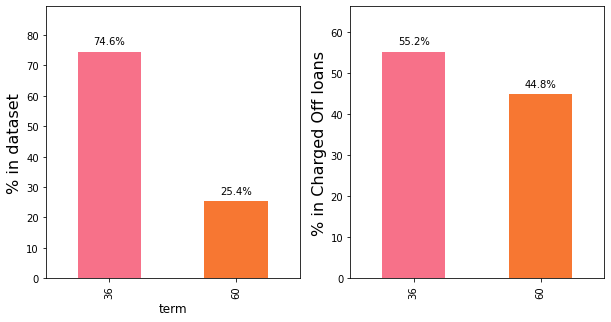

In [80]:
plt.figure(figsize=(10,5))
plot_percentages(master_loan, 'term')

**Observation:**
-  Around 75% of the total loans are given for duration of 3 years. while just 25% of the loans are those given for 5 years.
-  Among Charged Off loans, percentage of term 60 months rises to 45%. <mark>The higher term loans have a higher chance of default.</mark>  

---
#### Variable: purpose
Data_Dictionary: A category provided by the borrower for the loan request.

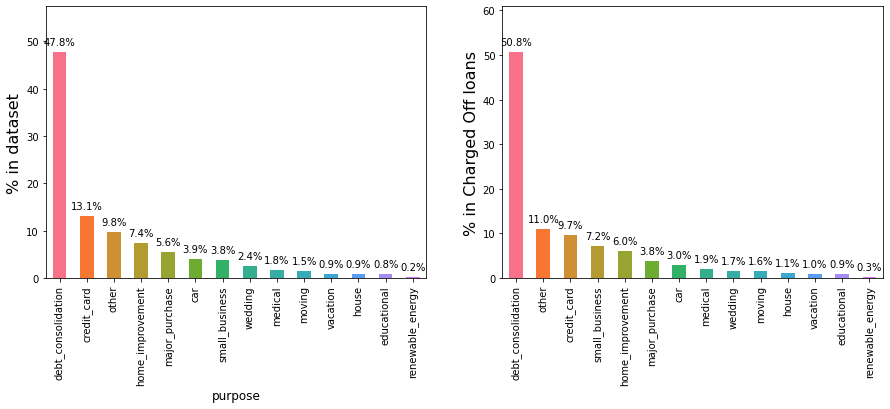

In [81]:
plt.figure(figsize=(15,5))
plot_percentages(master_loan, 'purpose')

Observation:

The category 'small_business' percentage doubles from 3.8 to 7.2 for Charged Off loans. Let's see how the categories of this variable behave.

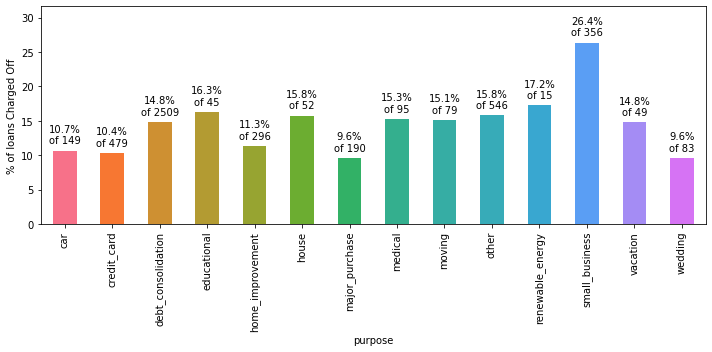

In [82]:
plt.figure(figsize=(10, 5))
plotLoanStatus(master_loan, 'purpose')

**Observation:**
-  <mark>26% of loans for small business are Charged Off. Making them the most risky purpose.</mark> 
- Approximately ~49% of the loans are issued for the purpose of dept consolidation.
- 17% of the loans for renewable_enrgy are charged Off, but the number is too less to be of significance. 

---
#### Variable: pub_rec_bankruptcy
Data_Dictionary: Number of public record bankruptcies

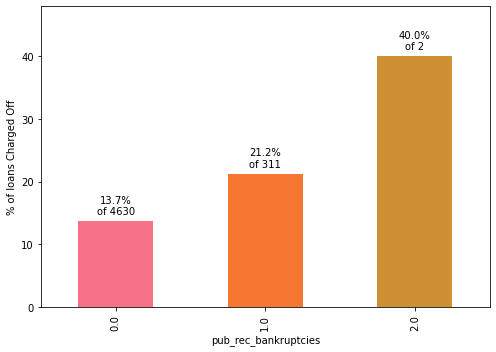

In [83]:
plt.figure(figsize=(7,5))
plotLoanStatus(master_loan, 'pub_rec_bankruptcies')

**Observation:**
-  <mark>The percentage of Charged Off loans is markedly higher when the borrower has a prior record of bankruptcy.</mark> 

---
#### Variable: int_rate
Data_Dictionary: Interest Rate on the loan.

In [84]:
master_loan.int_rate.describe()

count    35367.000000
mean        11.983468
std          3.702512
min          5.420000
25%          8.940000
50%         11.830000
75%         14.460000
max         24.400000
Name: int_rate, dtype: float64

<Figure size 1080x360 with 0 Axes>

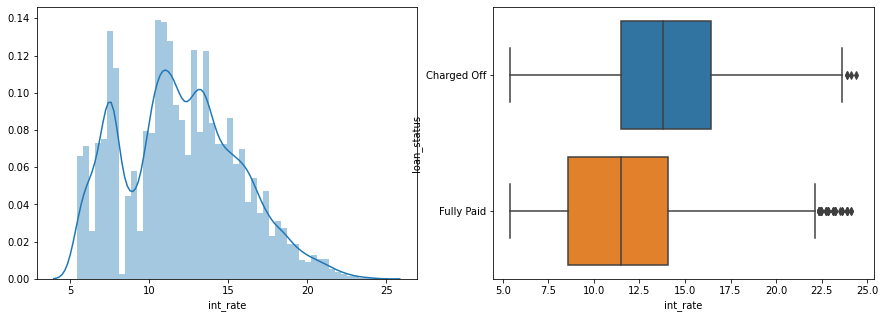

In [85]:
plt.figure(figsize=(15,5))
plot_distribution(master_loan, 'int_rate')

In [86]:
master_loan.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,4943.0,13.929828,3.647619,5.42,11.49,13.79,16.45,24.40
Fully Paid,30424.0,11.667243,3.613734,5.42,8.59,11.49,14.09,24.11


**Observation:**
-  Overall, the intrest rate varies from 5.42% to 24.4% with average intrest rate of 11.8%.
-  The intrest rate for Charged Off loans appear to be higher than for Fully paid. This is naturally expected. As, the risk increases the rate of interest imposed on the loan also increases. Let's analyze this more - 

In [87]:
master_loan['interest_rate_buckets'] = round(master_loan['int_rate'])

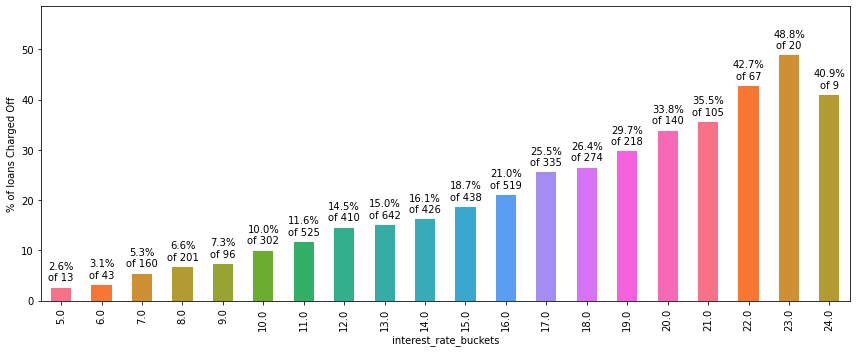

In [88]:
plt.figure(figsize=(12,5))
plotLoanStatus(master_loan, 'interest_rate_buckets')

---
#### Variable: installment
Data_Dictionary: The monthly payment owed by the borrower if the loan originates.

In [89]:
master_loan.installment.describe()

count    35367.000000
mean       324.043982
std        207.149088
min         16.080000
25%        167.840000
50%        280.620000
75%        426.640000
max       1305.190000
Name: installment, dtype: float64

<Figure size 1080x360 with 0 Axes>

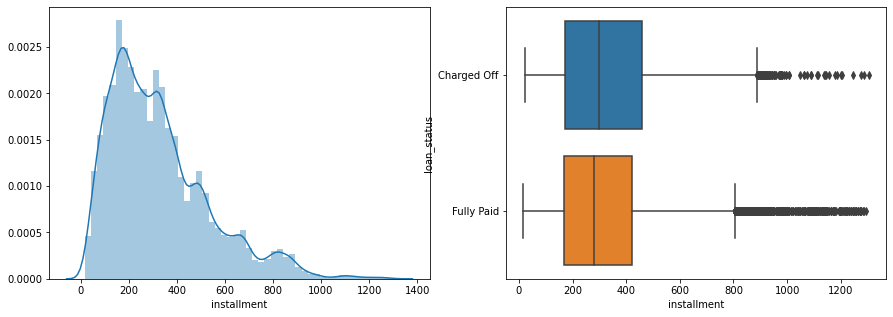

In [90]:
plt.figure(figsize=(15,5))
plot_distribution(master_loan, 'installment')

In [91]:
master_loan.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,4943.0,338.848452,214.527655,22.79,172.4350,298.33,458.3150,1305.19
Fully Paid,30424.0,321.638693,205.828423,16.08,167.2975,278.24,422.3075,1295.21


**Observation:**
-  installment amount varies largely between 170.08 to 420 with median of 280
-  loans Charged Off have high installment on average 

---
#### Variable: grade and sub_grade
Data_Dictionary: LC assigned loan grade and subgrade.

In [92]:
master_loan.grade.value_counts()

B    10718
A     9140
C     7181
D     4663
E     2481
F      902
G      282
Name: grade, dtype: int64

Let's find the relative frequencies of the unique sub_grade.

In [93]:
master_loan.sub_grade.value_counts(normalize=True).head()

A4    0.075268
B3    0.073204
A5    0.070320
B5    0.069104
B4    0.063534
Name: sub_grade, dtype: float64

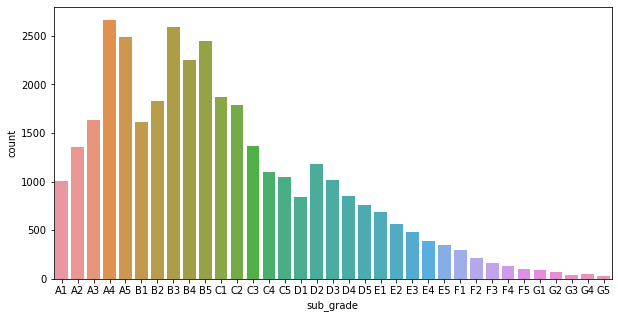

In [94]:
plt.figure(figsize=(10,5))
sns.countplot(master_loan['sub_grade'], order=sorted(master_loan.sub_grade.unique()))
plt.show()

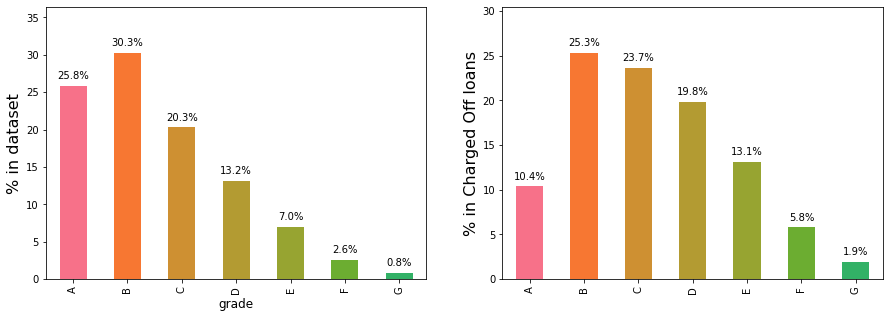

In [95]:
plt.figure(figsize=(15,5))
plot_percentages(master_loan, 'grade', True)

**Observation:**
-  Grade A and B loans are safe. The percentages in full dataset are much higher than percentages in Charged Off loans. 
- Grade D, E, F, G loans are less safe. <mark>We should plot grade by percentage Charged Off by category</mark>
- Lending Clubs grading system is working well. 

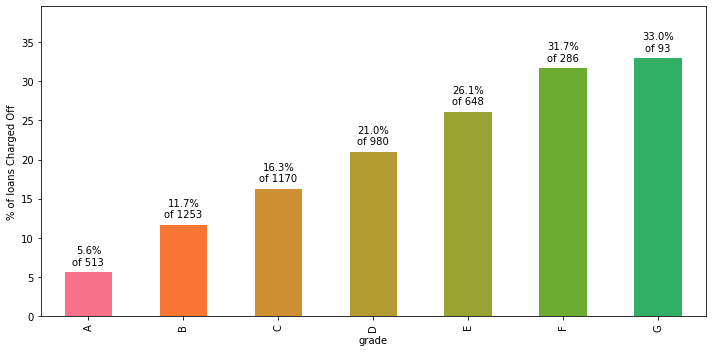

In [96]:
plt.figure(figsize=(10,5))
plotLoanStatus(master_loan, 'grade')

**Observation:**
- Nearly 30% of all loans in Grades F and G see a default. 
- Grade E onwards are risky, and less numerous. <mark>Lending Club should either refuse loans or charge high interest rates.</mark>

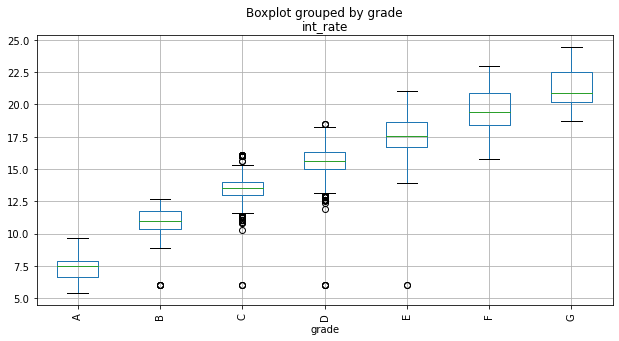

In [97]:
fig, ax = plt.subplots(figsize=(10,5))
master_loan.boxplot(column=['int_rate'],by='grade', ax=ax, rot=90)

**Observation:**
- Here we see that Lending Club is, correctly, charging higher interest rates for lower grade loans. 

---
#### Variable - emp_title
Data_Dictionary: The job title supplied by the Borrower when applying for the loan. Employer Title replaces Employer Name for all loans listed after 9/23/2013

In [98]:
top10_emp_title = master_loan.emp_title.value_counts(normalize=False).head(10)
top10_emp_title

US Army              128
Bank of America      106
IBM                   65
AT&T                  57
Kaiser Permanente     55
Wells Fargo           52
USAF                  51
UPS                   51
US Air Force          50
Walmart               44
Name: emp_title, dtype: int64

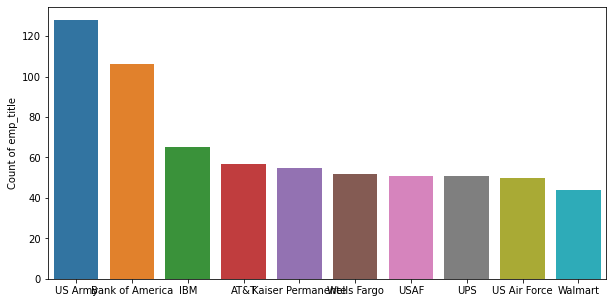

In [99]:
plt.figure(figsize=(10,5))
a=sns.barplot(x=top10_emp_title.index, y=top10_emp_title.values)
a.set_ylabel('Count of emp_title')
plt.show()

**Observation:**
-  Max of the loan takers are from the US Army, then Bank of America follwed by IBM and AT&T.
- Kaiser Permanents, wells Fargo, UPS, USAF, US Air Force and Walmart are also among the top 10 emp_title loans.
- <mark>The numbers per employer are quite low, and this variable is unlikely to have an impact on default rates.

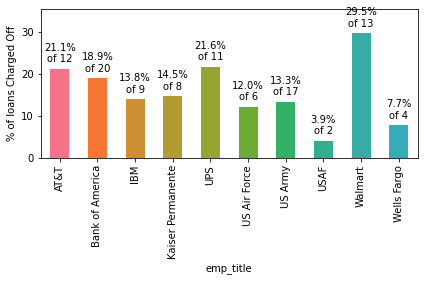

In [100]:
plotLoanStatus(master_loan[master_loan['emp_title'].isin(top10_emp_title.index.values)], 'emp_title')

---
#### Variable - emp_length
Data_Dictionary: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

In [101]:
master_loan.emp_length.value_counts(normalize=True)

10    0.226991
2     0.115447
0     0.112478
3     0.108378
4     0.090649
5     0.086041
1     0.083666
6     0.058303
7     0.046314
8     0.038482
9     0.033251
Name: emp_length, dtype: float64

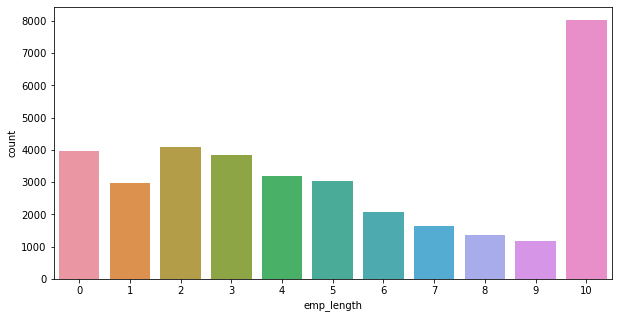

In [102]:
plt.figure(figsize=(10,5))
sns.countplot(master_loan['emp_length'], order=sorted(master_loan.emp_length.unique()))
plt.show()

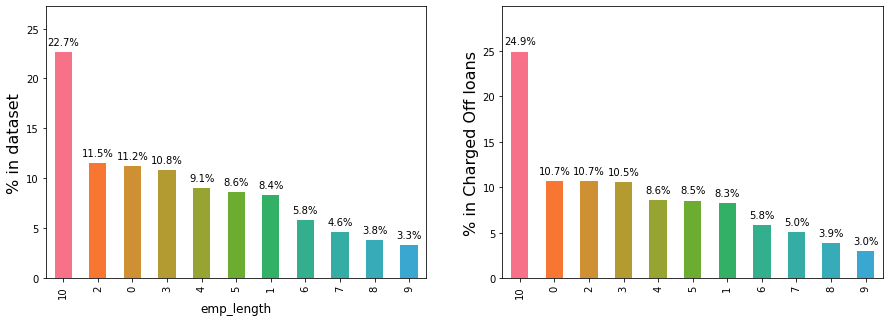

In [103]:
plt.figure(figsize=(15, 5))
plot_percentages(master_loan, 'emp_length')

**Observation:**
- 22.7% of the of loan taker have an employment length of more than 10 years.
- <mark>There is no impact of employment length to chance of loan default.</mark>

---
#### Variable - home_ownership
Data_Dictionary: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

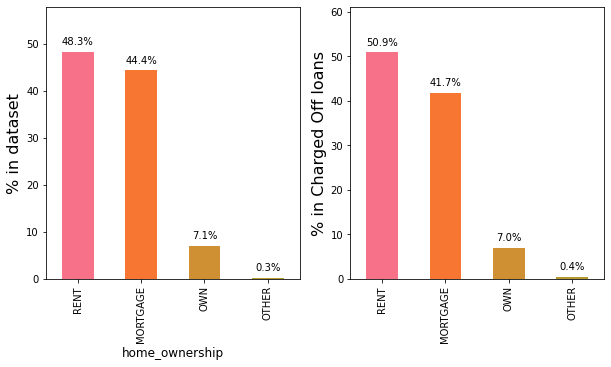

In [104]:
plt.figure(figsize=(10,5))
plot_percentages(master_loan, 'home_ownership')

**Observation:**
- <mark>There is no impact of home_ownership to propensity to default on loan.</mark>


#### Variable - annual_inc
Data_Dictionary: The self-reported annual income provided by the borrower during registration.

In [105]:
master_loan.annual_inc.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count    3.536700e+04
mean     6.909599e+04
std      6.396705e+04
min      4.000000e+03
10%      3.000000e+04
25%      4.150000e+04
50%      6.000000e+04
75%      8.250000e+04
90%      1.150000e+05
max      6.000000e+06
Name: annual_inc, dtype: float64

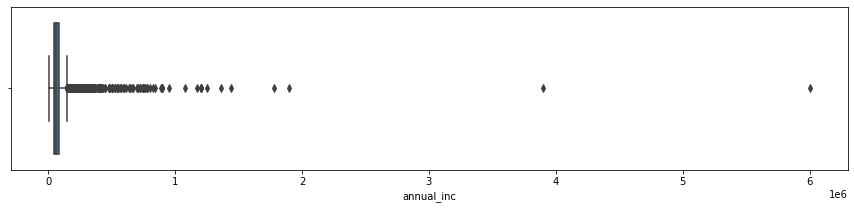

In [106]:
plt.figure(figsize=(15, 3))
sns.boxplot(x=master_loan['annual_inc'], data=master_loan)

The annual income reprted by the borrowers range from min of 4,000 to max of 6,000,000. <mark>There are clearly people with distinctly large income who applying for relatively small loans (up to a maximum of 35,000).</mark>
<br> Median annual income is around 60,000
<br> Most people have an annual income less than 115000

In [107]:
# Let's get rid of outliers to analyze annual income. 
# Keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
df = master_loan[np.abs(master_loan.annual_inc-master_loan.annual_inc.mean()) <= (3*master_loan.annual_inc.std())]

In [108]:
df.annual_inc.describe()

count     35122.000000
mean      66255.515193
std       35749.840874
min        4000.000000
25%       41004.000000
50%       59449.000000
75%       81969.000000
max      260000.000000
Name: annual_inc, dtype: float64

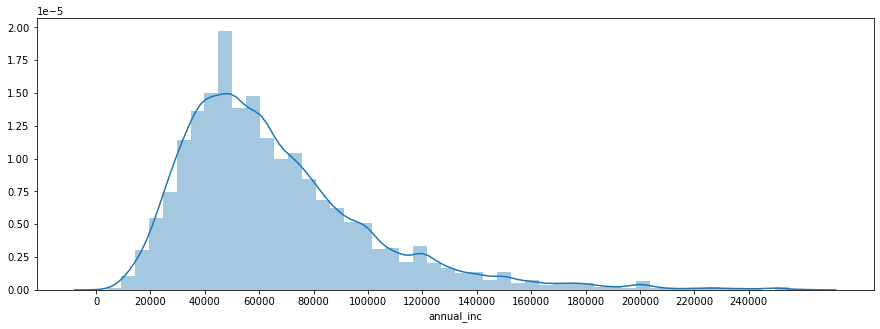

In [109]:
plt.figure(figsize=(15, 5))
sns.distplot(df['annual_inc'], hist_kws={'log':False})
plt.xticks(np.arange(0, 260000, 20000))
plt.show()

**Observation:**
-  10000 seems to be a good bin size to further analyze income as categories 

In [110]:
#Create Derived categorical variable
master_loan['income_bin'] = master_loan['annual_inc']/20000
#master_loan['income_bin'] = pd.cut(master_loan['annual_inc'], [x for x in range(0, 6010000, 10000)], labels=[str(x)+'-'+str(x+10)+'k' for x in range (0, 6000, 10)])
master_loan['income_bin'] = master_loan['income_bin'].astype(int)


[Text(0, 0, '0-10k'),
 Text(1, 0, '10-20k'),
 Text(2, 0, '20-30k'),
 Text(3, 0, '30-40k'),
 Text(4, 0, '40-50k'),
 Text(5, 0, '50-60k'),
 Text(6, 0, '60-70k'),
 Text(7, 0, '70-80k'),
 Text(8, 0, '80-90k'),
 Text(9, 0, '90-100k'),
 Text(10, 0, '100-110k'),
 Text(11, 0, '110-120k'),
 Text(12, 0, '120-130k'),
 Text(13, 0, '130-140k'),
 Text(14, 0, '140-150k'),
 Text(15, 0, '150-160k'),
 Text(16, 0, '160-170k'),
 Text(17, 0, '170-180k'),
 Text(18, 0, '180-190k'),
 Text(19, 0, '190-200k'),
 Text(20, 0, '200-210k')]

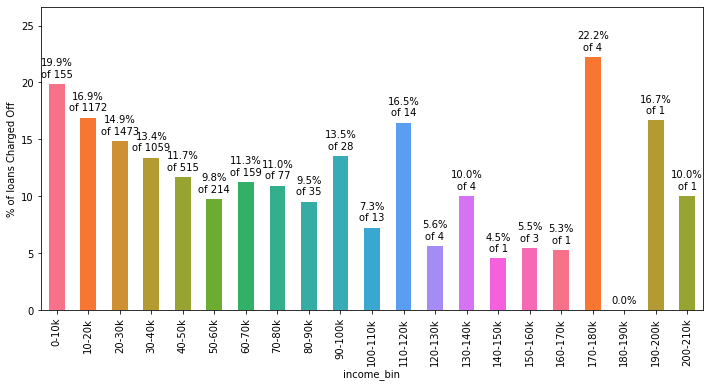

In [111]:
plt.figure(figsize=(10,5))
ax = plotLoanStatus(master_loan.loc[master_loan['income_bin']<21], 'income_bin')
ax.set_xticklabels([(str(int(x.get_text())*10)+'-'+str(int(x.get_text())*10+10)+'k') for x in ax.get_xticklabels()])

**Observation:**
- <mark>Loan defaults are higher for lower income, and progressively reduce as incomes go up.</mark>
- It will be interesting to see a bivariate analysis of defaults by income buckets and loan amounts later. 

---
#### Variable - verification_status
Data_Dictionary: Indicates if income was verified by LC, not verified, or if the income source was verified

In [112]:
master_loan.verification_status.value_counts()

Not Verified       14840
Verified           11363
Source Verified     9164
Name: verification_status, dtype: int64

Loans 'Verified' and 'Source Verified' status both imply that LC has cross checked the income value specified by the borrower and thus both statuses can be treated as one.

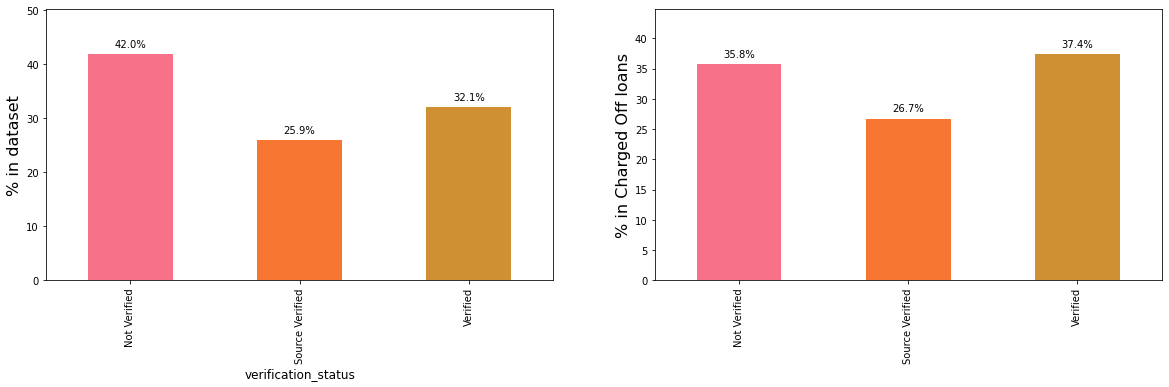

In [113]:
plt.figure(figsize=(20,5))
plot_percentages(master_loan, 'verification_status', True)

**Observation:**
-  Overall, it appears that there are more 'Non Verified' loans than the 'Source Verified' and 'Verified' loans. LC should take steps to verify these loans income so as to reduce the Charge Off percentage.
-  <mark>Verified loans show more charged Off percentage as compared to Not verified loans.</mark> This is unexpected and will be investigated later in bivariate analysis 

#### Variable: issue_d
Data_Dictionary: The month which the loan was funded

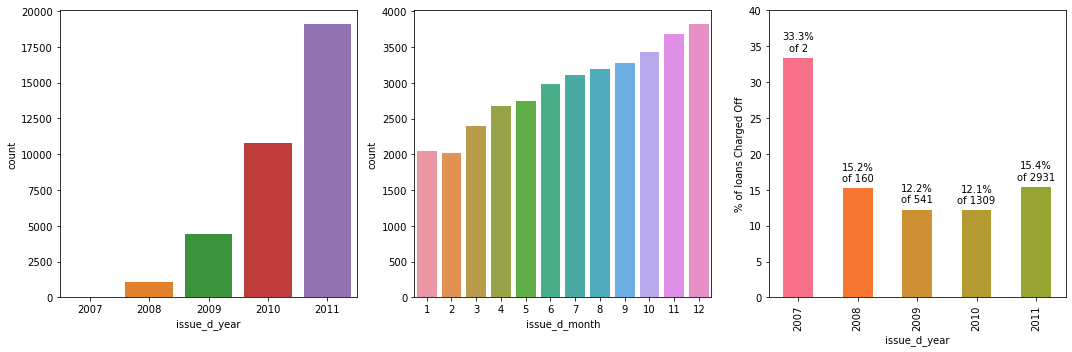

In [114]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.countplot(master_loan['issue_d_year'], order=sorted(master_loan.issue_d_year.unique()))

plt.subplot(1, 3, 2)
sns.countplot(master_loan['issue_d_month'], order=sorted(master_loan.issue_d_month.unique()))

#Fraction of loans charged off and fully Paid
plt.subplot(1, 3, 3)
plotLoanStatus(master_loan, 'issue_d_year')

plt.show()


**Observation:**
-  Over the years, LC as an organisation has been giving more loans. From Aug,2007 to 2011 the loans issued have risen significantly.
-  Within a year, the number of loan issued rises over the month from jan to Dec. Dcember is the month of the year were the maximum number of loans are being issued. Is the company trying to meet targets in the later months of the year? 
-  Year of loan has no significant effect on likelihood of default. 

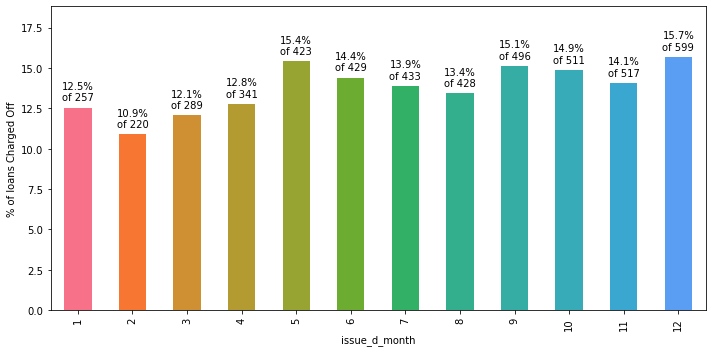

In [115]:
plt.figure(figsize=(10, 5))
plotLoanStatus(master_loan, 'issue_d_month')

**Observation:**
-  Month of loan is spread out and has no significant effect on likelihood of default. 

---
#### Variable - title
Data_Dictionary: The loan title provided by the borrower

In [116]:
master_loan.title.describe()

count                  35367
unique                 17662
top       Debt Consolidation
freq                    1975
Name: title, dtype: object

In [117]:
master_loan.title.value_counts().head(10)

Debt Consolidation           1975
Debt Consolidation Loan      1541
Personal Loan                 589
Consolidation                 462
debt consolidation            440
Credit Card Consolidation     325
Home Improvement              324
Debt consolidation            303
Personal                      281
Credit Card Loan              280
Name: title, dtype: int64

**Observation:**
- title column has 17662 unique values describing the loan by the borrower. This information is already captured with purpose column under 14 catergories of purpose. We can choose to drop this column.

In [118]:
master_loan = master_loan.drop('title',axis =1 )

---
#### Variable - addr_state
Data_Dictionary: The state provided by the borrower in the loan application

In [119]:
master_loan.addr_state.value_counts(normalize=True).head(10)

CA    0.180847
NY    0.095739
FL    0.071677
TX    0.069358
NJ    0.047134
IL    0.039048
PA    0.038822
VA    0.035626
GA    0.035429
MA    0.033393
Name: addr_state, dtype: float64

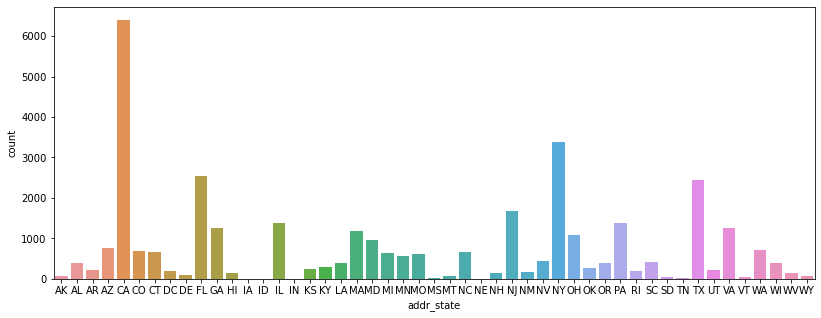

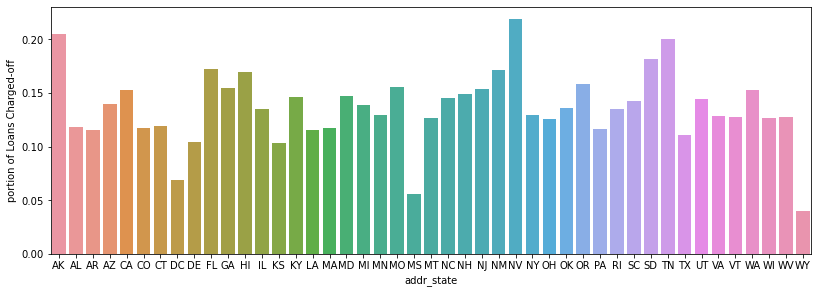

In [120]:
plt.figure(figsize=(30,5))
plt.subplot(1, 2, 1)
sns.countplot(master_loan['addr_state'], order=sorted(master_loan.addr_state.unique()))

#Fraction of loans charged off and fully Paid
charge_off_count = master_loan.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']  
Fully_paid_count = master_loan.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Fully Paid']  

plt.figure(figsize=(30,10))
plt.subplot(2, 2, 1)
a=sns.barplot(x=charge_off_count.index, y=charge_off_count.values)
a.set_ylabel('portion of Loans Charged-off')
#plt.subplot(1, 2, 2)
#b=sns.barplot(x=Fully_paid_count.index, y=Fully_paid_count.values)
#b.set_ylabel('portion of Loans Fully Paid')
plt.show()


**Observation:**
- Maximum loans ~18% are from California following that is 9.5% from New york state and Florida with 7%. This is to be expected as these are also the three most populous US states
- States with higher Charge Off rates have very low number of loans. The percentage is therefore NOT significant and should be ignored. Overall, this variable does not affect propensity to default. 


---
#### Variable - dti
Data_Dictionary: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [121]:
master_loan.dti.describe()

count    35367.000000
mean        13.403961
std          6.636540
min          0.000000
25%          8.320000
50%         13.500000
75%         18.640000
max         29.990000
Name: dti, dtype: float64

The dti index varies from min 0 to max of 30. The median dti is of 13.5

<Figure size 720x360 with 0 Axes>

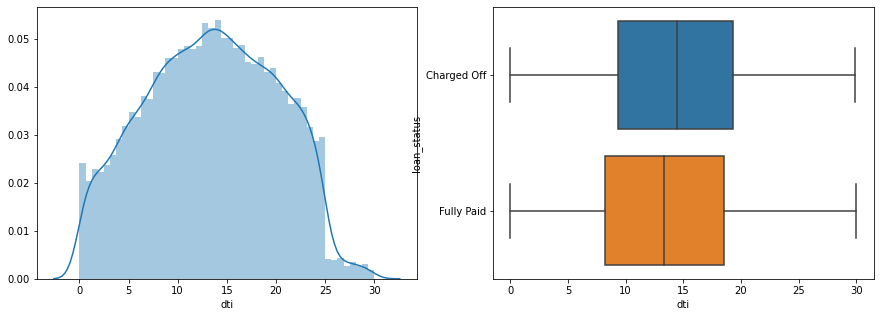

In [122]:
plt.figure(figsize=(10,5))

plot_distribution(master_loan, 'dti')

In [123]:
# Create derived variable 
master_loan['dti_bin'] = pd.cut(master_loan['dti'], [0,5,10,15,20,25,30], labels=['0-5','5-10','10-15','15-20','20-25','25-30'])


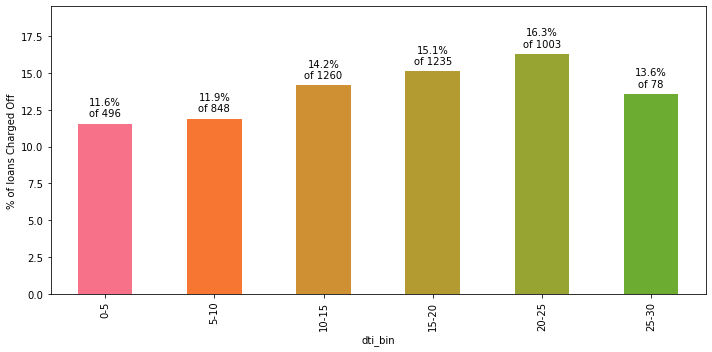

In [124]:
plt.figure(figsize=(10,5))
plotLoanStatus(master_loan, 'dti_bin')

**Observation:**
- When the dti or dept payment to income ratio is higher than 20, higher percentage of loans are Charged Off
- Higher the dti higher the chances of loan being Charged Off

---
#### Variable - delinq_2yrs
Data_Dictionary: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.

In [125]:
master_loan.delinq_2yrs.value_counts(normalize=True)

0     0.891594
1     0.083100
2     0.017361
3     0.005344
4     0.001499
5     0.000594
6     0.000283
7     0.000113
8     0.000057
9     0.000028
11    0.000028
Name: delinq_2yrs, dtype: float64

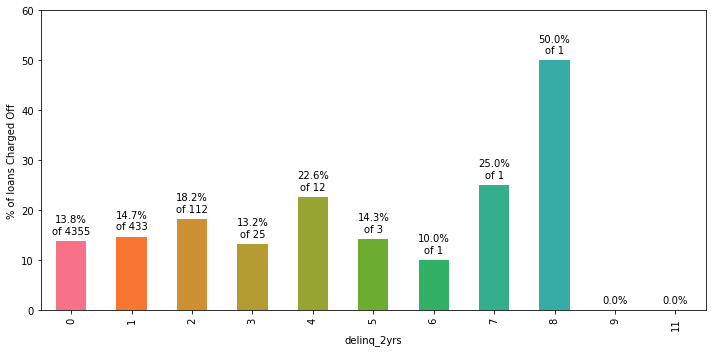

In [126]:
plt.figure(figsize=(10,5))
plotLoanStatus(master_loan, 'delinq_2yrs')

**Observation:**
-  The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years values ranges between 0 and 11.
- There are higher chances of default if this variable is greater than 1. 


---
#### Variable - earliest_cr_line
Data_Dictionary: The month the borrower's earliest reported credit line was opened.

In [127]:
master_loan.earliest_cr_line_year.value_counts(normalize=True).head()

2000    0.083326
1999    0.076201
1998    0.072638
2001    0.065259
1997    0.062403
Name: earliest_cr_line_year, dtype: float64

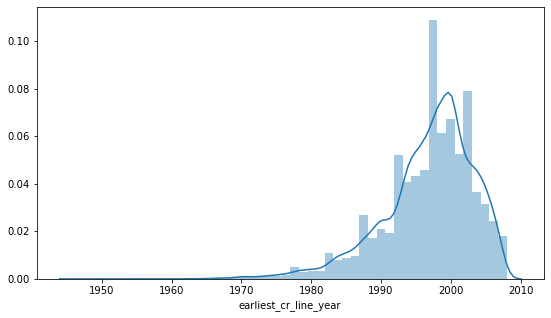

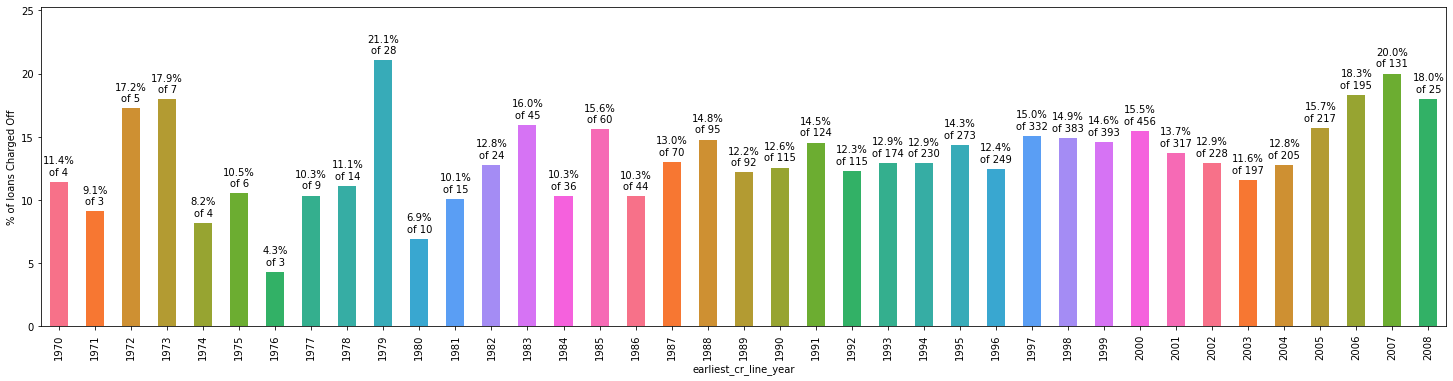

In [128]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
#sns.countplot(master_loan['earliest_cr_line_year'], order=sorted(master_loan.issue_d_year.unique()))
sns.distplot(master_loan['earliest_cr_line_year'])
#plt.subplot(1, 2, 2)
#sns.countplot(master_loan['earliest_cr_line_month'], order=sorted(master_loan.issue_d_month.unique()))
#plt.show()

plt.figure(figsize=(40,10))
plt.subplot(2, 2, 1)
plotLoanStatus(master_loan.loc[master_loan['earliest_cr_line_year'] > 1969], 'earliest_cr_line_year')
plt.show()


**Observation:**
-  8% of the loan applicants have 2000 as the year of earliest credit line.
- Newer borrowers are defauling more often. This is possibly related to the 2008 subprime crisis. 
- There was another economic crisis in US beginning in 1978 with double digit inflation. Newer borrowers of that time too defaulted more often. In general, those who take their first loans at times of recession, presumably young people, default more often. But this variable can be ignored in our analysis. 

---
#### Variable - inq_last_6mths
Data_Dictionary: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

In [129]:
master_loan.inq_last_6mths.value_counts(normalize=True)

0    0.485848
1    0.276359
2    0.147256
3    0.076427
4    0.007917
5    0.003478
6    0.001527
7    0.000877
8    0.000311
Name: inq_last_6mths, dtype: float64

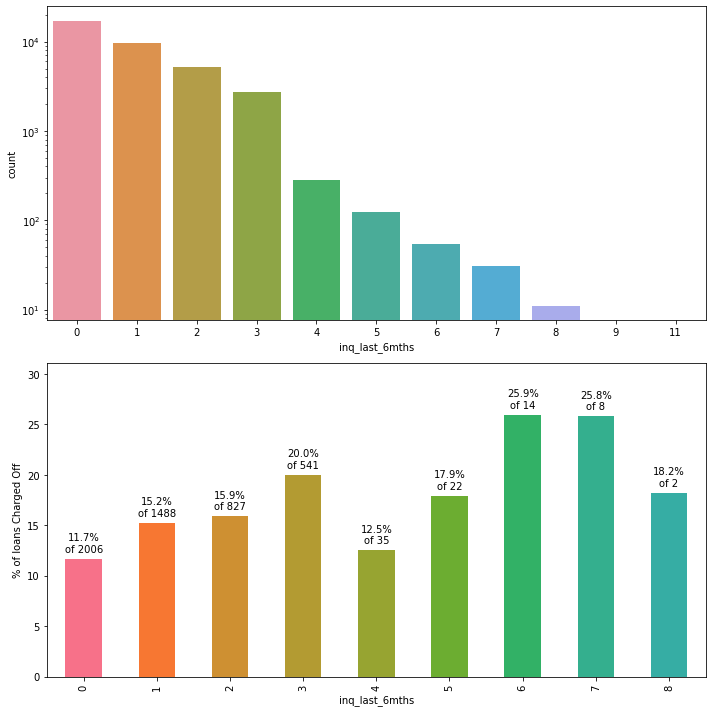

In [130]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
c=sns.countplot(master_loan['inq_last_6mths'], order=sorted(master_loan.delinq_2yrs.unique()))
c.set_yscale('log')

plt.subplot(2, 1, 2)
plotLoanStatus(master_loan, 'inq_last_6mths')
plt.show()

**Observation:**
-  48.5% of the borrowers do not make any inquiry
-  Those with more than 2 inquiries default at higher rates. 
- This is probably correlated to having more loans and can be ignored. The revolving line utilization will cover this.

---
#### Variable - open_acc
Data_Dictionary: The number of open credit lines in the borrower's credit file.

In [131]:
master_loan.open_acc.describe()

count    35367.000000
mean         9.332004
std          4.374975
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

The median of the distribution sugests that by large the borrower's seem to have 9 open credit lines.

<Figure size 1080x360 with 0 Axes>

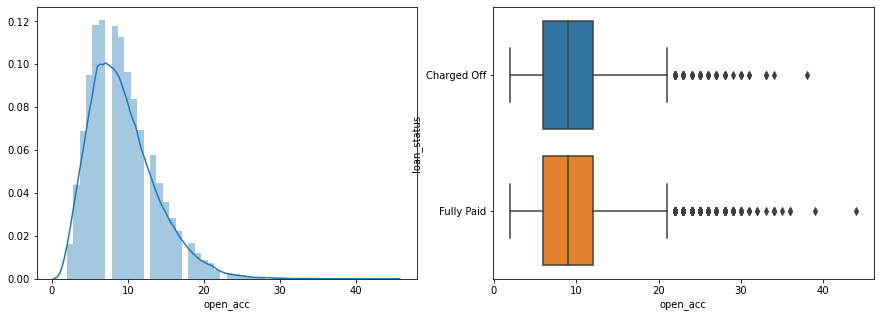

In [132]:
plt.figure(figsize=(15,5))
plot_distribution(master_loan, 'open_acc')
plt.show()

In [133]:
master_loan.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,4943.0,9.308517,4.491786,2.0,6.0,9.0,12.0,38.0
Fully Paid,30424.0,9.335820,4.355764,2.0,6.0,9.0,12.0,44.0


**Observation:**
-  The median of the distribution sugests that by large the borrower's seem to have 9 open credit lines.
- There is no significant difference in the credit lines of charged off and fully paid loans.

---
#### Variable - pub_rec
Data_Dictionary: Number of derogatory public records.

In [134]:
master_loan.pub_rec.value_counts(normalize=True)

0    0.947663
1    0.050838
2    0.001244
3    0.000198
4    0.000057
Name: pub_rec, dtype: float64

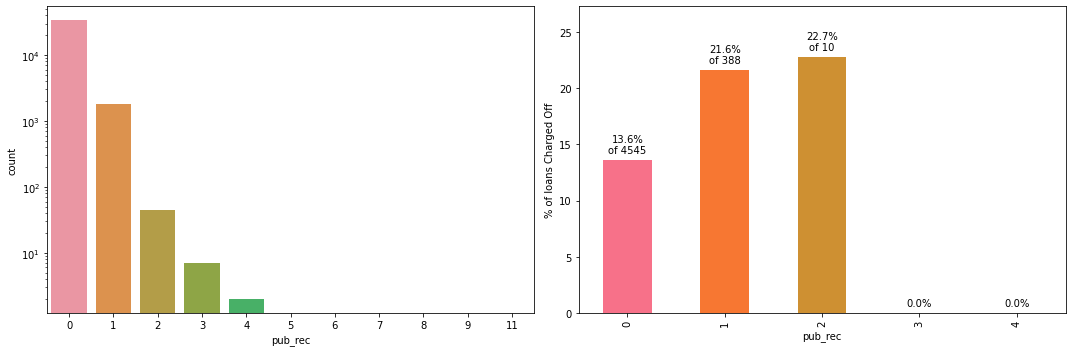

In [135]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
c=sns.countplot(master_loan['pub_rec'], order=sorted(master_loan.delinq_2yrs.unique()))
c.set_yscale('log')

plt.subplot(1, 2, 2)
plotLoanStatus(master_loan, 'pub_rec')
plt.show()



**Observation:**
- 94% have no Public derogatory records. 5% have 1 derogatory record.
- Having even 1 derogatory record increases the chances of Charge Off significantly.

---
#### Variable - revol_bal
Data_Dictionary: Total credit revolving balance

In [136]:
master_loan.revol_bal.describe()

count     35367.000000
mean      13367.676733
std       15678.460397
min           0.000000
25%        3782.000000
50%        8934.000000
75%       17064.500000
max      149588.000000
Name: revol_bal, dtype: float64

The revolving bal varies from min 0 to max of 150,000. The median revol_bal is of ~9000.

In [137]:
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
master_loan = master_loan[np.abs(master_loan.revol_bal-master_loan.revol_bal.mean()) <= (3*master_loan.revol_bal.std())]

The values vary a lot. Transforming to a log scale will help analyse better.

In [138]:
master_loan['revol_bal_log'] = master_loan['revol_bal'].apply(lambda x : np.log(x+1))

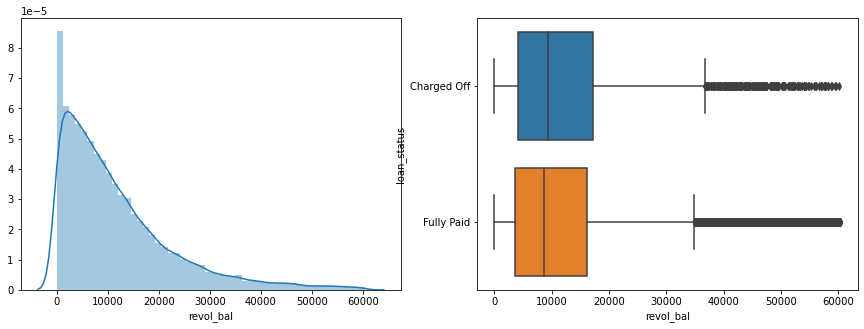

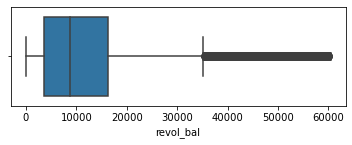

In [139]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.distplot(master_loan['revol_bal'])
plt.subplot(1, 2, 2)
sns.boxplot(x=master_loan['revol_bal'], y=master_loan['loan_status'], data=master_loan)
#sns.barplot(x='loan_status', y='annual_inc_log',data= master_loan)
plt.show()
plt.subplot(2, 1, 1)
sns.boxplot(x=master_loan['revol_bal'], data=master_loan)
plt.show()

In [140]:
master_loan.groupby('loan_status')['revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,4858.0,12453.837382,11330.139812,0.0,4161.0,9336.5,17212.5,60071.0
Fully Paid,29739.0,11641.208884,10974.614732,0.0,3612.0,8581.0,16138.5,60376.0


**Observation:**
-  There is no large difference in revolving balance mean for charged off an fully Paid loans

---
#### Variable - revol_util
Data_Dictionary:Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [141]:
master_loan.revol_util.describe()

count    34597.000000
mean        48.904609
std         28.210493
min          0.000000
25%         25.600000
50%         49.400000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

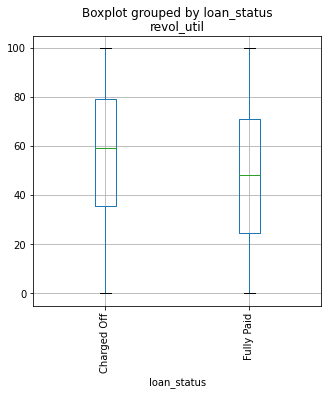

In [142]:
fig, ax = plt.subplots(figsize=(5,5))
df.boxplot(column=['revol_util'],by='loan_status', ax=ax, rot=90)

**Observation:**
-  The average utilization rate is around 49%
-  <mark>Average revolving Utilisation rate is seen to be higher for Charged Off loans than the Fully Paid loans</mark>. This requires more analysis. 

In [143]:
master_loan['revol_util_bin'] = round(master_loan['revol_util']/5)

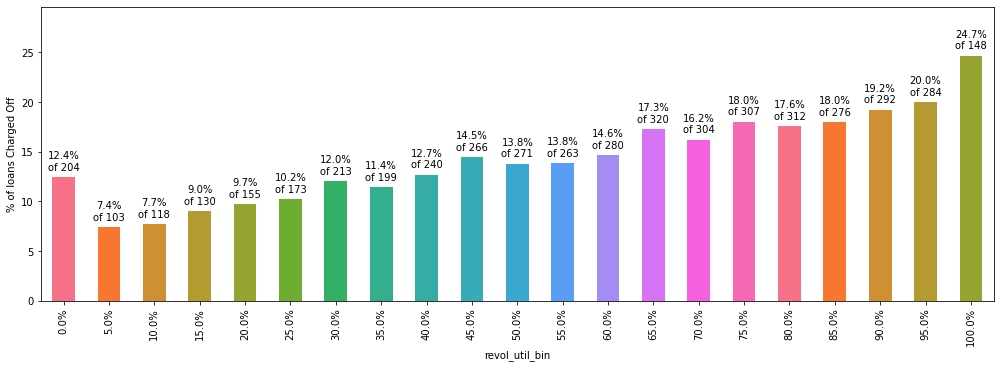

In [144]:
plt.figure(figsize=(14,5))
ax = plotLoanStatus(master_loan, 'revol_util_bin')
ax.set_xticklabels([(str(float(x.get_text())*5)+'%') for x in ax.get_xticklabels()])
plt.show()

---
#### Variable - total_acc
Data_Dictionary: The total number of credit lines currently in the borrower's credit file.

In [145]:
master_loan.total_acc.describe()

count    34597.000000
mean        22.006272
std         11.325562
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64

<Figure size 1080x360 with 0 Axes>

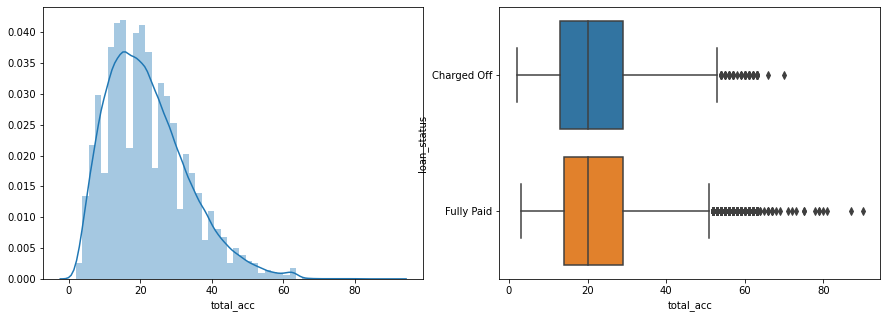

In [146]:
plt.figure(figsize=(15,5))

plot_distribution(master_loan, 'total_acc')

**Observation:**
-  The are approx. 22 average credit lines for the borrower's.
-  There is no big difference between the Charged Off and Fully Paid credit lines

---
#### Variable - out_prncp
Data_Dictionary: Remaining outstanding principal for total amount funded.

In [147]:
master_loan.out_prncp.value_counts()

0.0    34597
Name: out_prncp, dtype: int64

In [148]:
master_loan.groupby('loan_status')['out_prncp'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,4858.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fully Paid,29739.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Observation:**
-  As we are studying how the Fully paid loan are different from the Charged off loans, loan_status = current, has been ingnored for analysis. Therefore out_prncp variable can be removed or droped.

In [149]:
master_loan = master_loan.drop('out_prncp',axis=1)

---
#### Variable - out_prncp_inv
Data_Dictionary: Remaining outstanding principal for portion of total amount funded by investors

In [150]:
master_loan.out_prncp_inv.value_counts()

0.0    34597
Name: out_prncp_inv, dtype: int64

In [151]:
master_loan.groupby('loan_status')['out_prncp_inv'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,4858.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fully Paid,29739.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Observation:**
-  As we are studying how the Fully paid loan are different from the Charged off loans, loan_status = current, has been ignored for analysis. Therefore out_prncp_inv variable can be removed or dropped.

In [152]:
master_loan = master_loan.drop('out_prncp_inv',axis=1)

#### Variable - total_pymnt
Data_Dictionary: Payments received to date for total amount funded.

In [153]:
master_loan.total_pymnt.describe()

count    34597.000000
mean     11894.392156
std       8715.509427
min         33.730000
25%       5571.230000
50%       9771.780000
75%      16113.960000
max      58563.680000
Name: total_pymnt, dtype: float64

In [154]:
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
master_loan = master_loan[np.abs(master_loan.total_pymnt-master_loan.total_pymnt.mean()) <= (3*master_loan.total_pymnt.std())]

In [155]:
master_loan['total_pymnt'] = master_loan['total_pymnt'].apply(lambda x : np.log(x))

<Figure size 1080x360 with 0 Axes>

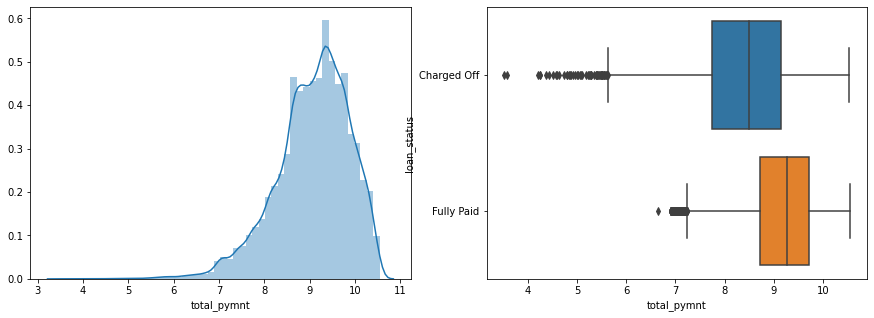

In [156]:
plt.figure(figsize=(15,5))
plot_distribution(master_loan, 'total_pymnt')
plt.show()

**Observation:**
-  The average payment received to date for the Charged Off loan is comparatively less than Fully Paid loans.
-  This variable may not be avaialble at the time of loan funding. We can drop this varaible from analysis.

In [157]:
master_loan = master_loan.drop('total_pymnt',axis=1)

---
#### Variable - total_pymnt_inv
Data_Dictionary: Payments received to date for portion of total amount funded by investors.

**Observation:**
-  This variable may not be avaialble at the time of loan funding. We can drop this variable from analysis.

In [158]:
master_loan = master_loan.drop('total_pymnt_inv',axis=1)

---
#### Variable - total_rec_prncp
Data_Dictionary: Principal received to date

**Observation:**
-  This variable may not be available at the time of loan funding. we can remove this variable from analysis.

In [159]:
master_loan = master_loan.drop('total_rec_prncp',axis=1)

---
#### Variable - total_rec_int
Data_Dictionary: Interest received to date.

**Observation:**
-  This variable may not be avaialble at the time of loan funding. We may drop this variable from analysis.

In [160]:
master_loan = master_loan.drop('total_rec_int',axis=1)

---
#### Variable - total_rec_late_fee
Data_Dictionary: Late fees received to date.

**Observation:**
-  The distribution of late fee is very insignificant to this analysis. we can drop this variable.
-  This variable may not be avaialble at the time of loan funding.

In [161]:
master_loan = master_loan.drop('total_rec_late_fee',axis=1)

---
#### Variable - recoveries
Data_Dictionary: post charge off gross recovery.

**Observation:**
-  Recoveries is only for the Charged Off loans.
- This Variable does not help as it comes to action after the loan has been Charged Off. Lets drop this variable.

In [162]:
master_loan = master_loan.drop('recoveries',axis=1)

---
#### Variable - collection_recovery_fee
Data_Dictionary: post charge off collection fee.

**Observation:**
-  collection_recovery_fee is only for the Charged Off loans.
- This Variable does not help as it comes to action after the loan has been Charged Off. Lets drop this variable.

---
#### Variable - last_pymnt_d
Data_Dictionary: Last month payment was received.

In [163]:
master_loan.last_pymnt_d.value_counts().head()

2013-03-01    940
2014-12-01    846
2013-05-01    828
2013-02-01    795
2012-03-01    781
Name: last_pymnt_d, dtype: int64

In [164]:
master_loan['last_pymnt_d_month']= master_loan['last_pymnt_d'].dt.month
master_loan['last_pymnt_d_year']= master_loan['last_pymnt_d'].dt.year

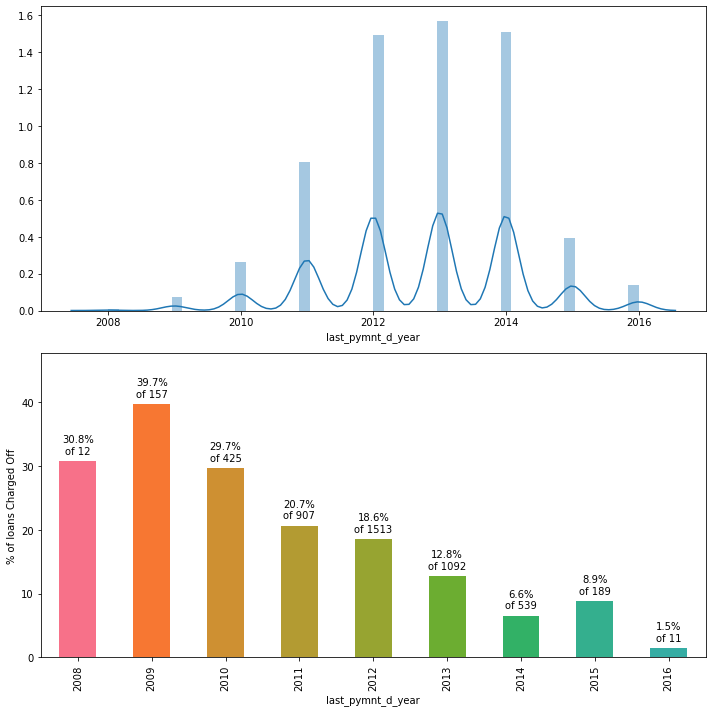

In [165]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
#sns.countplot(master_loan['earliest_cr_line_year'], order=sorted(master_loan.issue_d_year.unique()))
sns.distplot(master_loan['last_pymnt_d_year'])
#plt.subplot(1, 2, 2)
#sns.countplot(master_loan['earliest_cr_line_month'], order=sorted(master_loan.issue_d_month.unique()))
#plt.show()

plt.subplot(2, 1, 2)
plotLoanStatus(master_loan, 'last_pymnt_d_year')
plt.show()


**Observation:**
-  Overall, around 75% of the last payment dates are during 2012-2014 period.
-  40% of loans with a last payment date of 2009 are Charged Off. This is due to the 2008 subprime crisis. 
- This variable does not affect analysis and will be ignored. 

---
#### Variable - last_pymnt_amnt
Data_Dictionary: Last total payment amount received.

In [166]:
master_loan.last_pymnt_amnt.describe()

count    34074.000000
mean      2646.650918
std       4216.047508
min          0.010000
25%        220.370000
50%        570.625000
75%       3436.620000
max      36115.200000
Name: last_pymnt_amnt, dtype: float64

The value vary a lot. Lets conver it to log scale and plot to find trend.

In [167]:
master_loan['last_pymnt_amnt_log'] = master_loan['last_pymnt_amnt'].apply(lambda x : np.log(x+1))

<Figure size 1080x360 with 0 Axes>

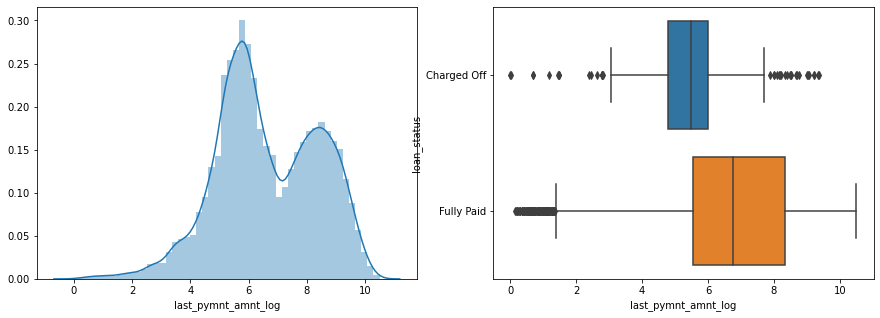

In [168]:
plt.figure(figsize=(15,5))

plot_distribution(master_loan, 'last_pymnt_amnt_log')
plt.show()

**Observation:**
-  The last Payment amount received is significantly lower for Charged Off loans as compared to the Fully Paid loans. This is expected in case of charged of loans 

---
#### Variable - last_credit_pull_d
Data_Dictionary: The most recent month LC pulled credit for this loan.

In [169]:
master_loan.last_credit_pull_d.value_counts().head()

2016-05-01    8347
2016-04-01    2106
2016-03-01    1009
2013-02-01     753
2016-02-01     654
Name: last_credit_pull_d, dtype: int64

In [170]:
master_loan['last_credit_pull_d_month']= master_loan['last_credit_pull_d'].dt.month
master_loan['last_credit_pull_d_year']= master_loan['last_credit_pull_d'].dt.year

In [171]:
master_loan.last_credit_pull_d_year.value_counts(normalize=True)

2016    0.372660
2014    0.162206
2015    0.145008
2013    0.135939
2012    0.106768
2011    0.054646
2010    0.018049
2009    0.004197
2008    0.000528
Name: last_credit_pull_d_year, dtype: float64

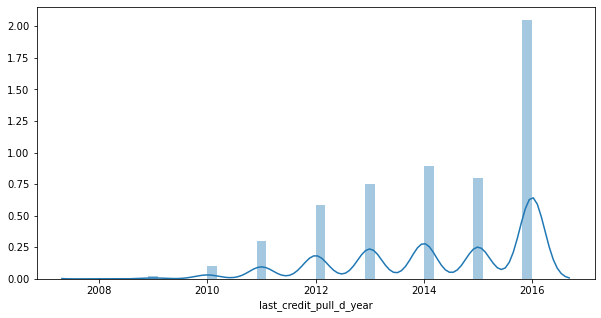

In [172]:
plt.figure(figsize=(10,5))
sns.distplot(master_loan['last_credit_pull_d_year'])
plt.show()


**Observation:**
-  Lending Club is pulling more credit reports in recent years, suggesting that the company is taking bad loans more seriously 
- This variable can be ignored in our analysis. 

--- 
#### Derived variable - ratio of loan amount to annual income 

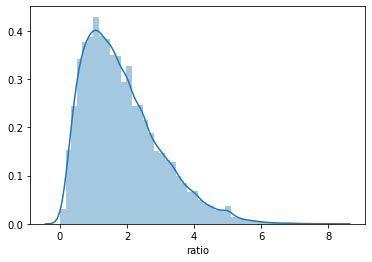

In [173]:
master_loan['ratio'] = master_loan['loan_amnt'] * 10 / master_loan['annual_inc']
sns.distplot(master_loan['ratio'])

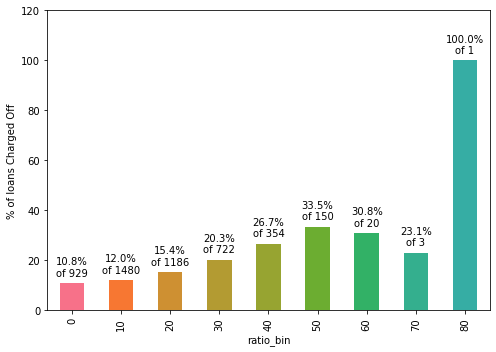

In [174]:
master_loan['ratio_bin'] = (master_loan['ratio'].astype(int)) * 10
plt.figure(figsize=(7,5))
plotLoanStatus(master_loan, 'ratio_bin')

**Observation:**
-  As long as loan amount is less than 20% of annual income, defaults are low. 
- <mark>Loan amounts of 30% of annual income or higher see a high rate of default.</mark>

### Bivariate Analysis

---
#### loan_amnt over time

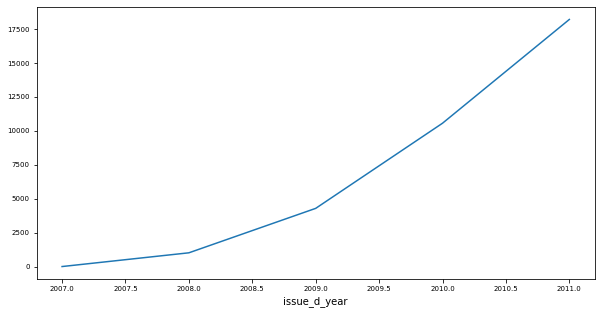

In [175]:
plt.figure(figsize=(10,5))
master_loan.groupby('issue_d_year').loan_amnt.count().plot(kind='line', fontsize=7)
plt.show()

---
#### Avg. loan_amnt over time

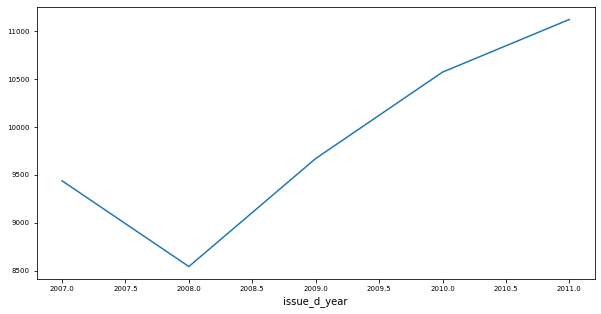

In [176]:
plt.figure(figsize=(10,5))
master_loan.groupby('issue_d_year').loan_amnt.mean().plot(kind='line', fontsize=7)
plt.show()

**Observation:**
-  Average loan amount dropped sharply when subprime mortgage crisis hit

---
####  loan_amnt and annual_inc

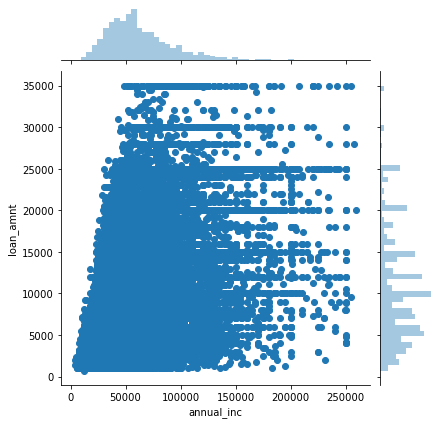

In [177]:
sns.jointplot('annual_inc', 'loan_amnt', master_loan.loc[master_loan['annual_inc']<260000])
plt.show()

**Observation:**
-  There are people with average income lower than 50000 taking loans of 25000 or higher. These would be risky loans. 

---
#### loan_amnt vs grade

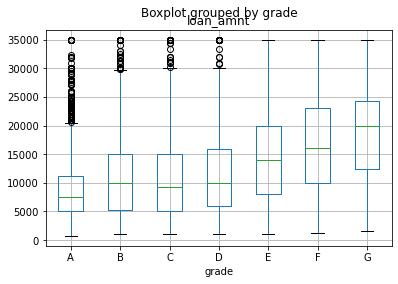

In [178]:
master_loan.boxplot(column='loan_amnt', by='grade')
plt.show()

 -  Larger loans generally appear to be given a lower grade, with the median loan amount for a grade G loan being almost 10000 higher than that of a grade A, B, or C loan.

---
##### annual income with grade

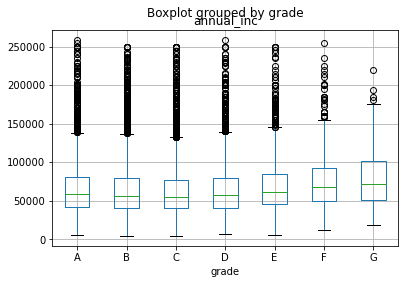

In [179]:
master_loan.loc[master_loan['annual_inc']<260000].boxplot(column='annual_inc', by='grade')
plt.show()

---
#### loan_amnt vs verification_status vs loan status

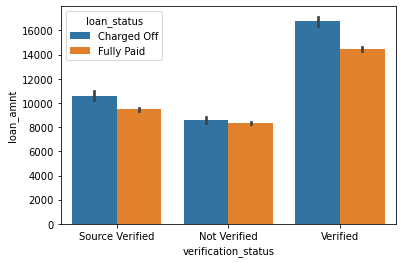

In [180]:
sns.barplot(x='verification_status', y='loan_amnt', hue="loan_status", data=master_loan, estimator=np.mean)

**Observation:**
- Higher loan amounts are Verified more often.  
- We already know that larger loans are less in number, but see a higher charge off rate.
- <mark>This, combined with previous observation, explains why verfied loans see a higher rate of default.</mark> It's not the verified status per se, it's the fact that higher loan amounts are riskier and are also verified more often by Lending Club. 

---
#### Interest Rate and Term

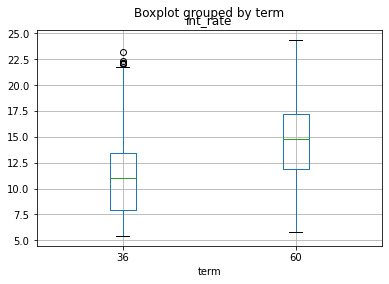

In [181]:
#master_loan.groupby('term').int_rate.mean().plot(kind='bar')
master_loan.boxplot(column='int_rate', by='term')
plt.show()

**Observation:**
-  Intrest rates are besed on term. Larger amounts were seen to be given for higher term. Ther rate of intrest associated with them is also high.

---
#### Interest Rate and Sub Grade

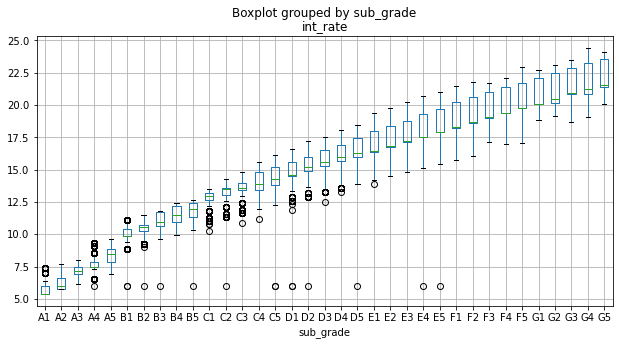

In [182]:
master_loan.boxplot(column='int_rate', by='sub_grade',figsize=(10,5))
plt.show()

**Observation:**
-  Intrest rates varies directly with the subgrade. Larger or worst the sub grade, higher are the rate of intrest for the loan.

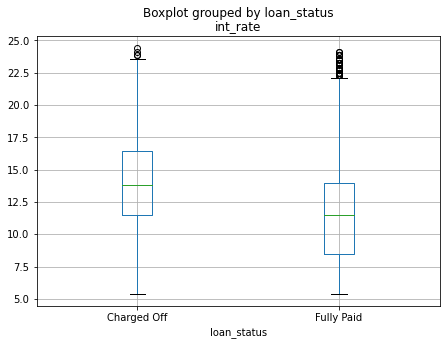

In [183]:
master_loan.boxplot(column='int_rate', by='loan_status',figsize=(7,5))

**Observation:**
- Loans at a higher intrest rate are more likely to be Charged Off.

#### Loan amount vs Grade vs Term

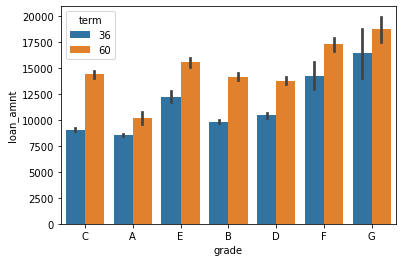

In [184]:
sns.barplot(x='grade', y='loan_amnt', hue="term", data=master_loan, estimator=np.mean)
plt.show()

**Observation:**
-  Our assumption made during univariate analysis is more evident with this plot. Higher loan amount are associated with lower grade for longer terms.

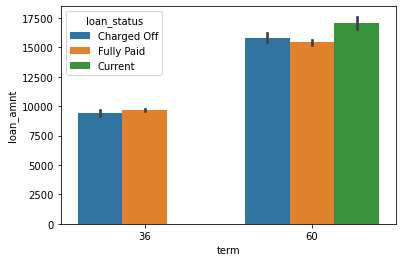

In [185]:
sns.barplot(x='term', y='loan_amnt', hue="loan_status", data=clean_loan, estimator=np.mean)
plt.show()

**Observation:**
-  Our assumption made during univariate analysis is more evident with this plot. Higher loan amount are associated with longer terms and see higher Charge Offs.


#### revol_util Vs grade Vs Loan Status


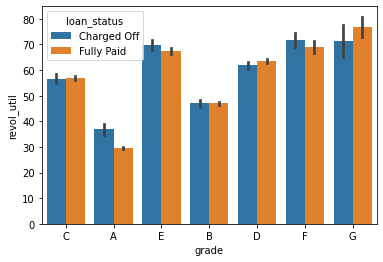

In [186]:
sns.barplot(x='grade', y='revol_util', hue="loan_status", data=master_loan, estimator=np.mean)
plt.show()

**Observation:**
-  revol_util and grade(and therefore int_rate) are correlated in some way. The revol_util is positivly correlated to the grade. As the grade goes from A to E the revol_util also increases. This may be because higer loan amounts are accosiated with higher grades.

#### Loan amount Vs addr_state vs loan Status


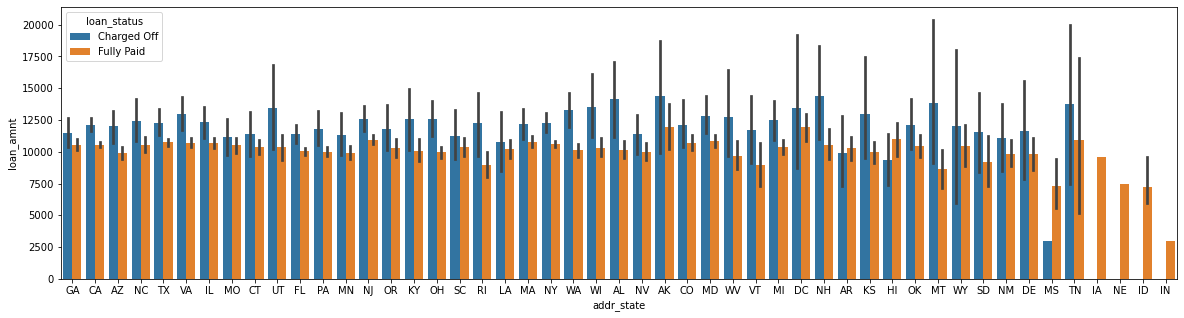

In [187]:
plt.figure(figsize=(20,5))
sns.barplot(x='addr_state', y='loan_amnt', hue='loan_status',data=master_loan, estimator=np.mean)
plt.show()

**Observation:**
-  States WY: Wyoming has the the highest average loan amount that was charged off. whats happening in this state is somthing LC can investigate into for this state.

#### revol_rate Vs int_rate

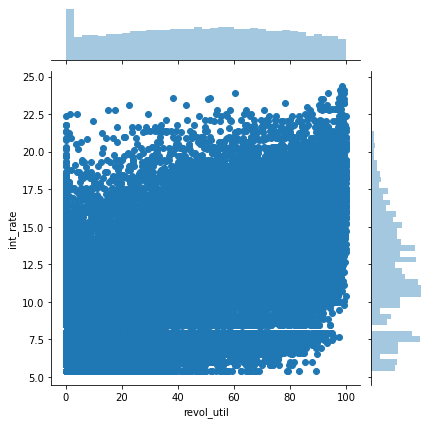

In [188]:
sns.jointplot('revol_util', 'int_rate', master_loan)

#### revol_util vs Grade

<Figure size 1440x360 with 0 Axes>

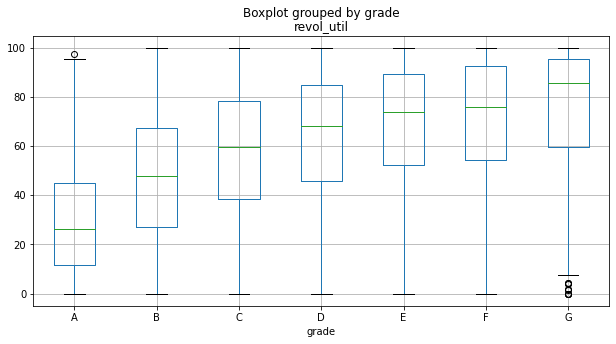

In [189]:
plt.figure(figsize=(20,5))
master_loan.boxplot(column='revol_util', by='grade',figsize=(10,5))
plt.show()

In [190]:
corr=master_loan.corr()
corr['loan_amnt']

loan_amnt                   1.000000
int_rate                    0.267460
installment                 0.924973
emp_length                  0.139453
annual_inc                  0.227570
dti                         0.063434
delinq_2yrs                -0.040534
inq_last_6mths              0.010051
open_acc                    0.166074
pub_rec                    -0.040321
revol_bal                   0.349543
revol_util                  0.061901
total_acc                   0.244417
collection_recovery_fee     0.084581
last_pymnt_amnt             0.441570
pub_rec_bankruptcies       -0.023352
earliest_cr_line_month     -0.013172
earliest_cr_line_year      -0.180141
issue_d_month               0.049346
issue_d_year                0.088558
interest_rate_buckets       0.267695
income_bin                  0.228479
revol_bal_log               0.243280
revol_util_bin              0.061512
last_pymnt_d_month          0.000539
last_pymnt_d_year           0.064966
last_pymnt_amnt_log         0.376585
l

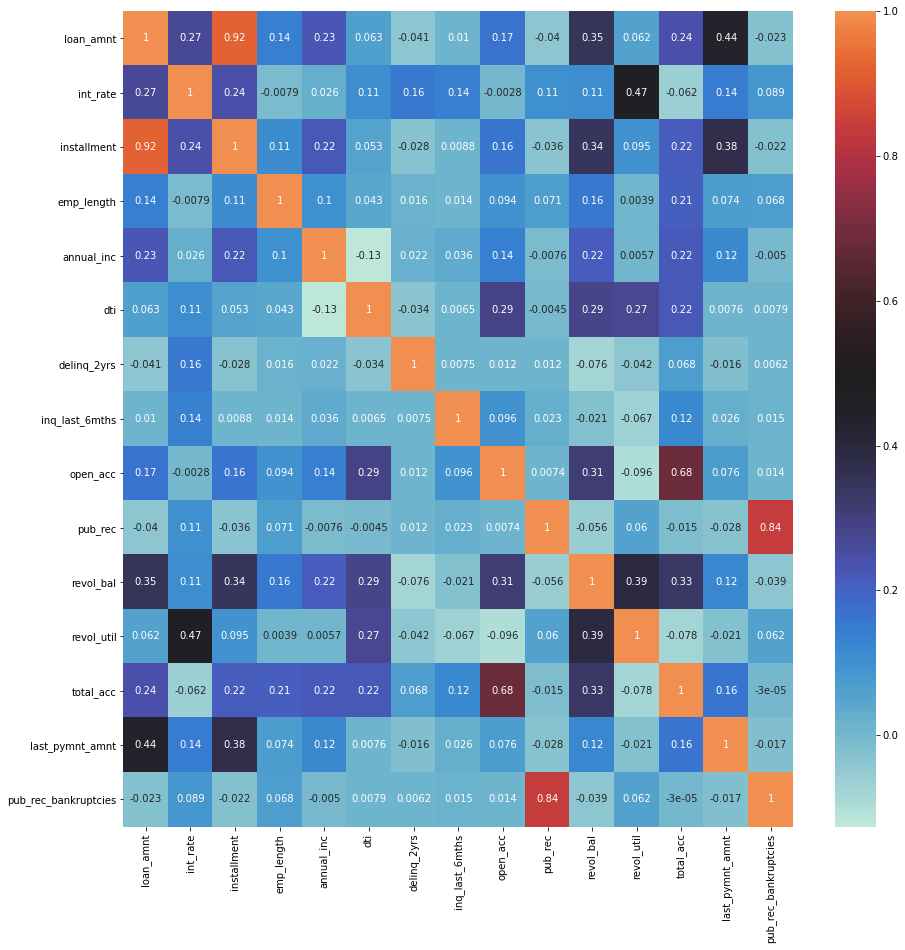

In [191]:
plt.figure(figsize=(15,15))
cont_var= ['loan_amnt', 'int_rate', 'installment',
       'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies']
corr = master_loan[cont_var].corr()
sns.heatmap(corr, annot=True, center=0.5)

**Observation:**
- loan_amnt is correlated to last_payment_amount with r factor.44, as expected
- int_rate is correlated to revol_util with r factor of .47 - This is good, as company is charging higher interest from riskier loan.
- <mark>loan_amnt revol_bal are correlated with r factor .35 - This is not good as it suggests that higher loan amount is being approved to riskier borrowers.</mark>
- delinq_2yrs is totally un-correlated with public record of bankruptcy. Therefore they represent distinct features with individual predictive value. 

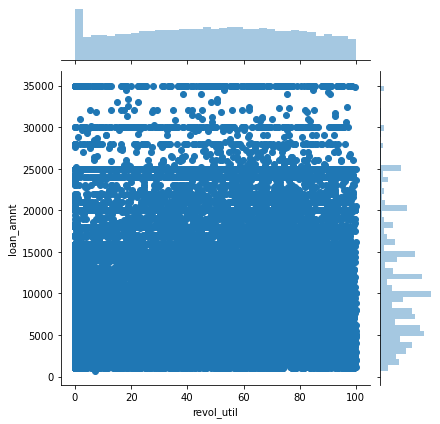

In [192]:
sns.jointplot('revol_util', 'loan_amnt', master_loan)

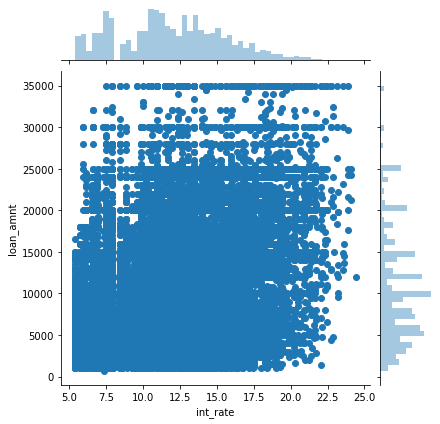

In [193]:
sns.jointplot('int_rate', 'loan_amnt', master_loan)

####  dti vs open_acc

In [194]:
master_loan['dti_bin']
master_loan.groupby('dti_bin').int_rate.mean()

dti_bin
0-5      11.052034
5-10     11.529209
10-15    11.972936
15-20    12.308956
20-25    12.565350
25-30     9.505806
Name: int_rate, dtype: float64

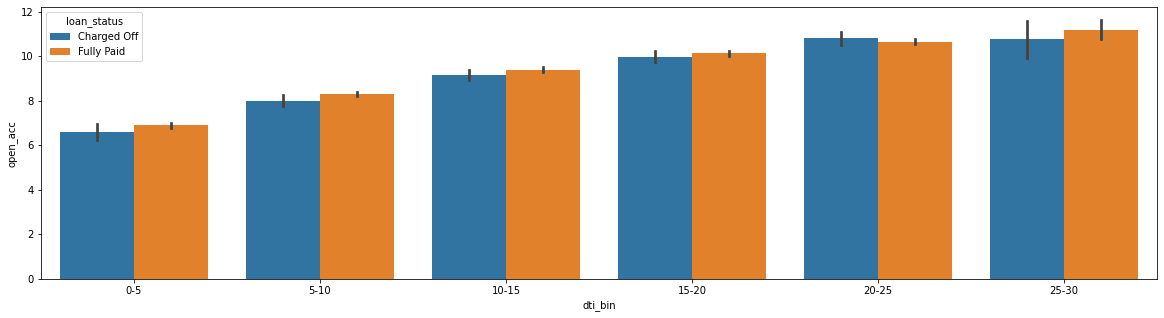

In [195]:
plt.figure(figsize=(20,5))
sns.barplot(x='dti_bin', y='open_acc', hue='loan_status',data=master_loan, estimator=np.mean)
plt.show()

**Observation:**
-  The dti increses with the number of open credit line in borrowers credit file.

####  delinq_2yr VS loan amount VS grade

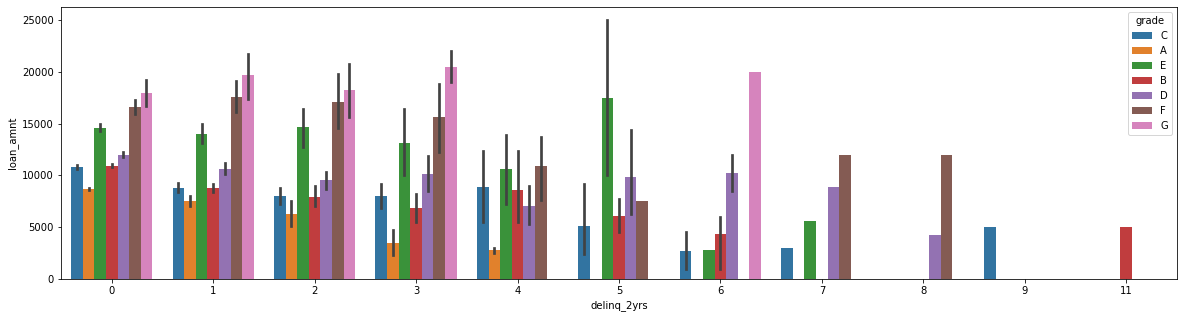

In [196]:
plt.figure(figsize=(20,5))
sns.barplot(x='delinq_2yrs', y='loan_amnt', hue='grade',data=master_loan, estimator=np.mean)
plt.show()

**Observation:**
-  Not many loans receive invstment with higher number of delinquencies(>3). Despite the low loan amount request, these loans are considered risky and are not invested much in.
- Lending club should further restrict their investment. We see loan amounts of >15000 on average for people having >=2 delinquencies. 

####  delinq_2yr VS int_rate  VS loan_status

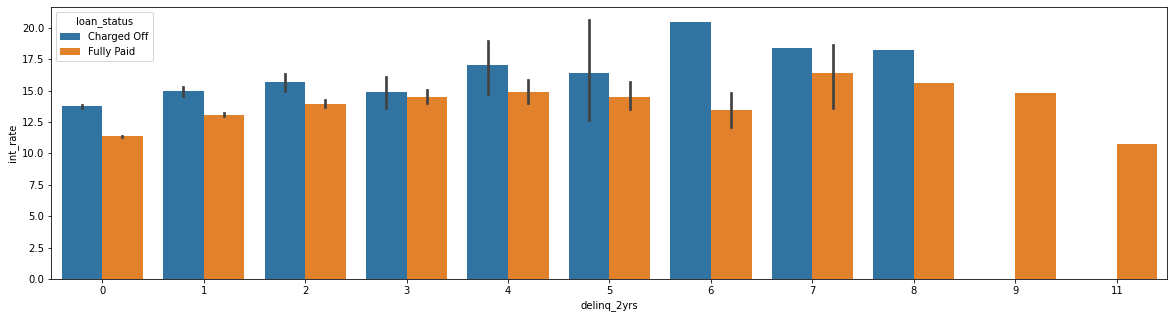

In [197]:
plt.figure(figsize=(20,5))
sns.barplot(x='delinq_2yrs', y='int_rate', hue='loan_status',data=master_loan, estimator=np.mean)
plt.show()

**Observation:**
- In genral, intrest rate offered inceases with the number of deliquency of the borrower.

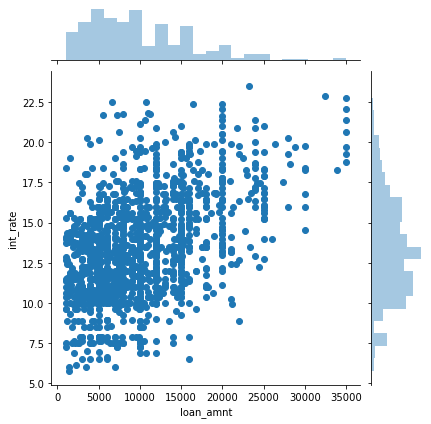

In [198]:
sns.jointplot('loan_amnt', 'int_rate', master_loan.loc[master_loan.pub_rec_bankruptcies > 0])

In [199]:
master_loan[['pub_rec', 'pub_rec_bankruptcies']].corr()

,pub_rec,pub_rec_bankruptcies
pub_rec,1.000000,0.839258
pub_rec_bankruptcies,0.839258,1.000000


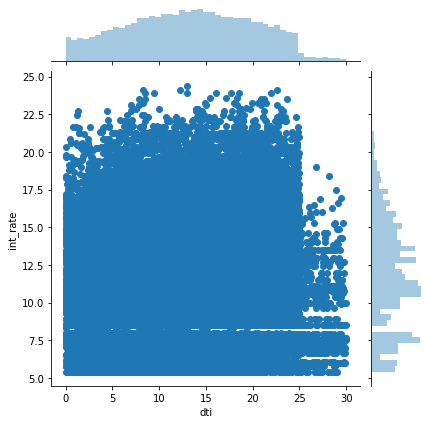

In [200]:
sns.jointplot('dti', 'int_rate', master_loan)

## Conclusion:

#### Major variables to consider for loan prediction:

        1. Loan Purpose
        2. Employment Length
        3. Interest Rate
        4. Annual Income
        5. Grade & Sub-grade
        6. Term
        7. Address State
        
### More Insights -

### Loan Purpose:
##### Charged Off Rate is high for loan purpose:

        1. small_business    = 26.27%
        2. renewable_energy  = 18.81%
        3. educational       = 17.03%
        

### Employment Length: 
##### Charged Off Rate is high for employment length:
        
        1.  0 year (< 1 year)
        2.  1 year
##### We see that the Charged Off rate increases for peopple with less employment length.

### Interest Rate:
##### Charged Off Rate is high  for interest rate:
        
        1. 20-25   = 34.44%
        2. 15-20   = 23.51%
###### As the Interest Rate increases, Charge Off Rate Increases


### Annual Income:
##### Charged Off Rate is high for Annual Income:
        
        1. 0-20000       = 19.93%
        2. 20000-40000   = 17.43%
        3. 40000-60000   = 14.90%
##### So, as the Anual Income decreases, Charge Off Rate Increases


### Grade & Sub-grade:
##### Most of the Charged off applicants belong to Grade B, C and D.
##### Of the Grade B, C and D, most of the Charged off applicants belong to Sub Grades:
        
        1. Grade B => B3, B5, B4
        2. Grade C => C3, C4, C5
        3. Grade D => D3, D4, D5

##### Also as the Grade increases, Charged Off Rate increases. Top Order:
        
        1. G
        2. F
        3. E
        4. D
        5. C
        6. B
        7. A


### Term:
##### Charge Off Rate increases as the Term increases.


### Address State:
##### Charged Off Rate is high for Address State:
        
        1. NE (Nebraska)     = 60.00%
        2. NV (Nevada)       = 21.75%
        3. SD (South Dakota) = 18.75%
        4. AK (Alaska)       = 17.72%
        5. FL (Florida)      = 17.54%

        *NE (Nebraska) has a total of 5 loans out of which 3 were charged-off.